In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np

In [15]:
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision,torch
import torch.nn as nn
root = '/rawdata'
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.MNIST(root=root, train=True, transform=trans, download=True)
test_set = torchvision.datasets.MNIST(root=root, train=False, transform=trans, download=True)
kwargs = {'num_workers': 0, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(
             dataset=train_set,
             batch_size=65536,
             shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(
            dataset=test_set,
            batch_size=65536,
            shuffle=False, **kwargs)
import random
def randomize(a,b):
    c = list(zip(a,b))
    random.shuffle(c)
    a,b = zip(*c)
    return np.array(a).astype(np.float32),np.array(b).astype(np.float32)

In [16]:
for batch_idx, (data, target) in enumerate(train_loader):
    train_input = data.numpy()
    train_targets = target.numpy()
for batch_idx, (data, target) in enumerate(test_loader):
    test_input = data.numpy()
    test_targets = target.numpy()

In [17]:
import torch.nn.functional as F
def torchDiffWMW( target,pred, gamma=0.5, p = 2):    
    mask = target.type(torch.cuda.ByteTensor)
    x = torch.masked_select(pred, 1+(-1)*mask).view(1,-1)
    y = torch.masked_select(pred, mask).view(-1,1)
    xn = x.expand(y.size(0), x.size(1))
    yn = y.expand(y.size(0), x.size(1))
    mask = (xn-yn) < gamma
    ur = torch.pow((xn-yn-gamma),p)*mask.type(torch.cuda.FloatTensor)
    return torch.sum(ur) / torch.sum(target) / torch.sum(1-target)

def torchSigWMW( target,pred, beta=2):    
    mask = target.type(torch.cuda.ByteTensor)
    x = torch.masked_select(pred, 1+(-1)*mask).view(1,-1)
    y = torch.masked_select(pred, mask).view(-1,1)
    xn = x.expand(y.size(0), x.size(1))
    yn = y.expand(y.size(0), x.size(1))
    ur = F.sigmoid(-beta*(xn-yn))
    return torch.sum(ur) / torch.sum(target) / torch.sum(1-target)
def torchPairSigWMW( target,pred, pred_class, other_class,beta=2):    
    mask = target.type(torch.cuda.ByteTensor)
    oc = (target == other_class)
    pc = (target == pred_class)
    x = torch.masked_select(pred, oc).view(1,-1)
    y = torch.masked_select(pred, pc).view(-1,1)
    xn = x.expand(y.size(0), x.size(1))
    yn = y.expand(y.size(0), x.size(1))
    ur = F.sigmoid(-beta*(xn-yn))
    return torch.sum(ur) / torch.sum(oc).float() / torch.sum(pc).float()
def npSigWMW( target,pred, beta=2):
    
    x = pred[target == 0.0].reshape((1,-1))
    y = pred[target == 1.0].reshape((-1,1))    
    xn = np.repeat(x, y.shape[0], 0)
    yn = np.repeat(y, x.shape[1], 1)
    ur = 1.0 / (1.0 + np.exp(beta*(xn-yn)))
    
    return ur.sum() / float(np.sum(target)) / float(np.sum(1.0 - target))



def npDiffWMW(target,pred, gamma=0.5, p = 2): 
    
    x = pred[target == 0.0].reshape((1,-1))
    y = pred[target == 1.0].reshape((-1,1))    
    xn = np.repeat(x, y.shape[0], 0)
    yn = np.repeat(y, x.shape[1], 1)
    mask = (xn-yn) < gamma    
    ur = np.power((xn-yn-gamma),p)*mask
    return ur.sum() / float(np.sum(target)) / float(np.sum(1.0 - target))
def npAUC(target,pred, gamma=0.0, p = 2): 
    
    x = pred[target == 0.0].reshape((1,-1))
    y = pred[target == 1.0].reshape((-1,1))    
    xn = np.repeat(x, y.shape[0], 0)
    yn = np.repeat(y, x.shape[1], 1)
    mask = (xn-yn) < gamma    
    ur = mask
    return ur.sum() / float(np.sum(target)) / float(np.sum(1.0 - target))
class StratifiedSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, class_vector, target_frequencies=None,random_seed=0):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        target_frequencies : a list
            a list of desired frequencies for each class
            this should be a list of floats or None 
        """
        self.class_vector = class_vector
        self.target_frequencies = target_frequencies
        np.random.seed(random_seed)
        random.seed(random_seed)

    def gen_sample_array(self):
        y = self.class_vector.numpy().astype(int)
        classes = np.unique(y)
        if self.target_frequencies == None: self.target_frequencies = [1.0] * len(classes)
        class_draw = []      
        max_num_in_class = max(np.bincount(y))
        for c in classes:
            class_indices = np.where(y == c)[0]
            repeats = max_num_in_class * self.target_frequencies[c] // len(class_indices) + 1
            class_indices = class_indices.repeat(repeats)
            np.random.shuffle(class_indices)
            class_draw.append(class_indices[:max_num_in_class])

        class_draw = np.array(class_draw)
        class_draw = np.transpose(class_draw).flatten()   
        return class_draw[:len(y)]

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
def makeLenet(softmax = True):
    if softmax:
        return nn.Sequential(
                nn.Conv2d(in_channels=1,out_channels=20,kernel_size=5),
                nn.MaxPool2d(2),
                nn.Conv2d(in_channels=20,out_channels=50,kernel_size=5),
                nn.MaxPool2d(2),
                Flatten(),
                nn.Linear(4*4*50,500),
                nn.ReLU(inplace=True),
                nn.Linear(500,10),
                nn.Softmax()            
            ).cuda()
    else:
        return nn.Sequential(
                nn.Conv2d(in_channels=1,out_channels=20,kernel_size=5),
                nn.MaxPool2d(2),
                nn.Conv2d(in_channels=20,out_channels=50,kernel_size=5),
                nn.MaxPool2d(2),
                Flatten(),
                nn.Linear(4*4*50,500),
                nn.ReLU(inplace=True),
                nn.Linear(500,10),    
            ).cuda()
MNIST_lenet = makeLenet()

In [18]:
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim
from sklearn import metrics
def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

num_classes = 10       
iterations = 10000
u = 0.9

gamma_lr = 0.0001
alpha = 0.75
def ovoWMWLoss(pred, target, beta):
    ret = 0
    for i in range(num_classes):
        for k in range(num_classes):
            if i!=k:
                ret += torchPairSigWMW(target, pred[:,i], i, k, beta)
    return -ret / (float(num_classes) * (float(num_classes) - 1.0) )

def WMWLoss(pred, target, beta):
    ret = 0
    for i in range(num_classes):
        ret += torchSigWMW((target == i).long().float(), pred[:,i], beta)
    return -ret / float(num_classes)
def npWMWLoss(pred, target, beta):
    ret = 0
    for i in range(num_classes):
        t = npSigWMW((target == i).astype(np.float32), pred[:,i], beta)
        ret += t
    return -ret / float(num_classes)
def makeSig(beta):
    return lambda x,y : WMWLoss(x,y,beta)
def makeOvoSig(beta):
    return lambda x,y : ovoWMWLoss(x,y,beta)
def train(loss_function, iterations=10000,lr = 0.001,decay=0.0005): # nn.CrossEntropyLoss(size_average = True)
    MNIST_lenet = makeLenet()
    iteration = 0
    optimizer = optim.Adam(MNIST_lenet.parameters(), lr=lr, weight_decay=decay)    
    finish = False
    pbar = tqdm(total=iterations)
    ll_losses = []
    all_test_auc=[]
    ret = []
    while not finish:
        # train 
        for data,labels in train_loader:
            data = Variable(data.cuda())
            labels = Variable(labels.cuda()).long()          
            #djust_learning_rate(optimizer, lr * np.power((1 + gamma_lr * iteration) , (-alpha)))
            optimizer.zero_grad()            
            output = MNIST_lenet(data)
            loss = loss_function(output, labels)
            loss.backward() 
            ll_losses.append(loss.cpu().data.numpy()[0])
            optimizer.step()
            iteration += 1
            pbar.update(1)
            
            # test
            if iteration % 100 == 0:
                test_output_torch = MNIST_lenet(test_input_balanced)
                test_output = test_output_torch.cpu().data.numpy()
                aucs = []
                for i in range(num_classes):
                    for k in range(num_classes):
                        if i != k:
                            fpr, tpr, thresholds = metrics.roc_curve(test_targets_balanced_np[np.logical_or(test_targets_balanced_np == i, test_targets_balanced_np == k)],
                                                                     test_output[np.logical_or(test_targets_balanced_np == i, test_targets_balanced_np == k),i], pos_label=i)   
                            auc = metrics.auc(fpr, tpr)  
                            #auc2 = npDiffWMW((test_targets_balanced_np == i).astype(int), test_output[:,i], gamma=0)
                            #print (auc,auc2)
                            aucs.append(auc)    
                all_test_auc.append(np.mean(aucs))    
                accuracy = metrics.accuracy_score(test_targets_balanced_np, np.argmax(test_output, axis=1)) 
                ret.append([np.mean(aucs), accuracy, loss.cpu().data.numpy()[0]])
                print ('Multiclass ROC', np.mean(aucs), 'Accuracy', accuracy, 'loss', loss.cpu().data.numpy()[0])
            if iteration >= iterations: 
                finish = True
                break
        
        #print ('Multiclass ROC', np.mean(aucs), 'Accuracy', accuracy, 'loss', loss.cpu().data.numpy()[0])
    return ret, MNIST_lenet

In [19]:
def makeTestSet(mu, p,seed=0):
    
    test_nums = []
    for i in range(10):
        n = 500
        if i >= mu*10:
            n /= p
        test_nums.append(int(n))
    print (test_nums)
    test_input_r, test_targets_r = randomize(test_input, test_targets)
    test_input_balanced = flatten([test_input_r[test_targets_r == i][:test_nums[int(i)]] for i in range(10)])
    test_targets_balanced = flatten([test_targets_r[test_targets_r == i][:test_nums[int(i)]] for i in range(10)])
   
    test_input_balanced_np, test_targets_balanced_np = randomize(test_input_balanced, test_targets_balanced)
    test_input_balanced = torch.utils.data.TensorDataset(torch.from_numpy(test_input_balanced_np), 
                                                      torch.from_numpy(test_targets_balanced_np))
    test_loader = torch.utils.data.DataLoader(
             dataset=test_input_balanced,batch_size=65536,
             shuffle=False, num_workers=int(0), pin_memory=True, drop_last=True)
    test_input_balanced = Variable(torch.from_numpy(test_input_balanced_np).cuda(), volatile=True)
    test_targets_balanced = Variable(torch.from_numpy(test_targets_balanced_np).cuda(), volatile=True)
    return test_input_balanced,test_targets_balanced,test_input_balanced_np, test_targets_balanced_np,test_loader


In [20]:
test_input_balanced,test_targets_balanced,test_input_balanced_np, test_targets_balanced_np,test_loader = makeTestSet(0.8, 500)

[500, 500, 500, 500, 500, 500, 500, 500, 1, 1]


In [21]:

flatten = lambda l: np.array([item for sublist in l for item in sublist])   

mu = 0.8
p = 2500 
class_nums = []
for i in range(10):
    n = 5000
    if i < mu*10:
        n /= p
    class_nums.append(int(n))
print (class_nums)
train_input_balanced = flatten([train_input[train_targets == i][:class_nums[int(i)]] for i in range(10)])
train_targets_balanced = flatten([train_targets[train_targets == i][:class_nums[int(i)]] for i in range(10)])



train_input_balanced_np, train_targets_balanced_np = randomize(train_input_balanced, train_targets_balanced)


from torch.autograd import Variable
train_input_balanced = torch.utils.data.TensorDataset(torch.from_numpy(train_input_balanced_np), 
                                                      torch.from_numpy(train_targets_balanced_np))



sampler = StratifiedSampler(torch.from_numpy(train_targets_balanced_np))
train_loader = torch.utils.data.DataLoader(
             dataset=train_input_balanced,sampler=sampler,batch_size=64,
             shuffle=False, num_workers=int(0), pin_memory=True, drop_last=True)



_, model = train(makeOvoSig(2.0),2000)
_, cemodel = train(nn.CrossEntropyLoss(size_average = True),2000)


[2, 2, 2, 2, 2, 2, 2, 2, 5000, 5000]


A Jupyter Widget

Multiclass ROC 0.927342533333 Accuracy 0.410794602699 loss -0.880116
Multiclass ROC 0.908127866667 Accuracy 0.359820089955 loss -0.88052
Multiclass ROC 0.914326977778 Accuracy 0.385807096452 loss -0.879411
Multiclass ROC 0.9117168 Accuracy 0.388305847076 loss -0.880286
Multiclass ROC 0.902752844444 Accuracy 0.422788605697 loss -0.880222
Multiclass ROC 0.908108466667 Accuracy 0.425037481259 loss -0.880104
Multiclass ROC 0.911352222222 Accuracy 0.408295852074 loss -0.879223
Multiclass ROC 0.903527911111 Accuracy 0.372813593203 loss -0.880449
Multiclass ROC 0.937811333333 Accuracy 0.558220889555 loss -0.879539
Multiclass ROC 0.917889733333 Accuracy 0.463768115942 loss -0.879804
Multiclass ROC 0.907927422222 Accuracy 0.466266866567 loss -0.874294
Multiclass ROC 0.898056177778 Accuracy 0.383308345827 loss -0.88055
Multiclass ROC 0.916755422222 Accuracy 0.486256871564 loss -0.880562
Multiclass ROC 0.8910664 Accuracy 0.337831084458 loss -0.879732
Multiclass ROC 0.8977692 Accuracy 0.4157921039

A Jupyter Widget

Multiclass ROC 0.927780311111 Accuracy 0.301849075462 loss 1.46377
Multiclass ROC 0.939983422222 Accuracy 0.403048475762 loss 1.46127
Multiclass ROC 0.916961244444 Accuracy 0.244627686157 loss 1.46202
Multiclass ROC 0.909785111111 Accuracy 0.306596701649 loss 1.46274
Multiclass ROC 0.908577244444 Accuracy 0.28135932034 loss 1.46155
Multiclass ROC 0.923586 Accuracy 0.364317841079 loss 1.46182
Multiclass ROC 0.891572177778 Accuracy 0.278610694653 loss 1.46236
Multiclass ROC 0.906626933333 Accuracy 0.4007996002 loss 1.46986
Multiclass ROC 0.874388444444 Accuracy 0.291854072964 loss 1.46204
Multiclass ROC 0.876963333333 Accuracy 0.338830584708 loss 1.46132
Multiclass ROC 0.886072222222 Accuracy 0.34007996002 loss 1.46634
Multiclass ROC 0.901412755556 Accuracy 0.371564217891 loss 1.46162
Multiclass ROC 0.9034012 Accuracy 0.33908045977 loss 1.46168
Multiclass ROC 0.896018311111 Accuracy 0.310594702649 loss 1.46136
Multiclass ROC 0.902985511111 Accuracy 0.40379810095 loss 1.46134
Multiclass R

In [22]:
import numpy as np
flatten = lambda l: np.array([item for sublist in l for item in sublist])   
wmwaucs_sig = []
ceaucs_sig = []


for mu in [0.2,0.5,0.8]:
    for p in [1,500,1000,2500,5000]:
        class_nums = []
        for i in range(10):
            n = 5000
            if i < mu*10:
                n /= p
            class_nums.append(int(n))
        print (class_nums)
        for count in range(3):                     
            
            random.seed(count)
            torch.cuda.manual_seed(count)        
            np.random.seed(count)            
            train_input_balanced, train_targets_balanced = randomize(test_input, test_targets)
            train_input_balanced = flatten([train_input_balanced[train_targets_balanced == i][:class_nums[int(i)]] for i in range(10)])
            train_targets_balanced = flatten([train_targets_balanced[train_targets_balanced == i][:class_nums[int(i)]] for i in range(10)])  
            
            
            test_nums = [500,500,500,500,500,500,500,500,500,500]
            test_input_r, test_targets_r = randomize(test_input, test_targets)
            test_input_balanced = flatten([test_input_r[test_targets_r == i][:test_nums[int(i)]] for i in range(10)])
            test_targets_balanced = flatten([test_targets_r[test_targets_r == i][:test_nums[int(i)]] for i in range(10)])

            train_input_balanced_np, train_targets_balanced_np = randomize(train_input_balanced, train_targets_balanced)
            test_input_balanced_np, test_targets_balanced_np = randomize(test_input_balanced, test_targets_balanced)

            from torch.autograd import Variable
            train_input_balanced = torch.utils.data.TensorDataset(torch.from_numpy(train_input_balanced_np), 
                                                                  torch.from_numpy(train_targets_balanced_np))
            test_input_balanced = torch.utils.data.TensorDataset(torch.from_numpy(test_input_balanced_np), 
                                                                  torch.from_numpy(test_targets_balanced_np))


            sampler = StratifiedSampler(torch.from_numpy(train_targets_balanced_np))
            train_loader = torch.utils.data.DataLoader(
                         dataset=train_input_balanced,sampler=sampler,batch_size=64,
                         shuffle=False, num_workers=int(0), pin_memory=True, drop_last=True)
            test_loader = torch.utils.data.DataLoader(
                         dataset=test_input_balanced,batch_size=65536,
                         shuffle=False, num_workers=int(0), pin_memory=True, drop_last=True)

            test_input_balanced = Variable(torch.from_numpy(test_input_balanced_np).cuda(), volatile=True)
            test_targets_balanced = Variable(torch.from_numpy(test_targets_balanced_np).cuda(), volatile=True)
            
            wmwaucs_sig.append(train(makeOvoSig(2.0), 2000))
            ceaucs_sig.append(train(nn.CrossEntropyLoss(size_average = True),2000))
            


[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


A Jupyter Widget


Multiclass ROC 0.993759155556 Accuracy 0.9244 loss -0.858344
Multiclass ROC 0.997944666667 Accuracy 0.9552 loss -0.866302
Multiclass ROC 0.999111511111 Accuracy 0.969 loss -0.845826
Multiclass ROC 0.999173422222 Accuracy 0.9704 loss -0.855452
Multiclass ROC 0.999606 Accuracy 0.9808 loss -0.875335
Multiclass ROC 0.999585511111 Accuracy 0.9824 loss -0.867202
Multiclass ROC 0.999535755556 Accuracy 0.9758 loss -0.864715
Multiclass ROC 0.999237444444 Accuracy 0.9636 loss -0.874667
Multiclass ROC 0.999401822222 Accuracy 0.9668 loss -0.858192
Multiclass ROC 0.999779066667 Accuracy 0.9848 loss -0.863552
Multiclass ROC 0.999792311111 Accuracy 0.9868 loss -0.879796
Multiclass ROC 0.999785422222 Accuracy 0.9856 loss -0.867634
Multiclass ROC 0.999717333333 Accuracy 0.984 loss -0.880228
Multiclass ROC 0.999886866667 Accuracy 0.9864 loss -0.873181
Multiclass ROC 0.9998056 Accuracy 0.9842 loss -0.868
Multiclass ROC 0.9997672 Accuracy 0.9854 loss -0.877417
Multiclass ROC 0.999832355556 Accuracy 0.987

A Jupyter Widget

Multiclass ROC 0.993826488889 Accuracy 0.9174 loss 1.51001
Multiclass ROC 0.997034266667 Accuracy 0.9476 loss 1.50279
Multiclass ROC 0.998389666667 Accuracy 0.9554 loss 1.53798
Multiclass ROC 0.999015844444 Accuracy 0.9696 loss 1.49084
Multiclass ROC 0.999143666667 Accuracy 0.9688 loss 1.50319
Multiclass ROC 0.999300333333 Accuracy 0.9802 loss 1.5009
Multiclass ROC 0.9995952 Accuracy 0.98 loss 1.53274
Multiclass ROC 0.999708555556 Accuracy 0.988 loss 1.4913
Multiclass ROC 0.999721533333 Accuracy 0.9864 loss 1.49441
Multiclass ROC 0.999677177778 Accuracy 0.986 loss 1.46243

Multiclass ROC 0.999532866667 Accuracy 0.9874 loss 1.46243
Multiclass ROC 0.999621311111 Accuracy 0.9858 loss 1.46179
Multiclass ROC 0.999828933333 Accuracy 0.9896 loss 1.46993
Multiclass ROC 0.999851644444 Accuracy 0.9912 loss 1.48131
Multiclass ROC 0.999836755556 Accuracy 0.989 loss 1.46667
Multiclass ROC 0.999959066667 Accuracy 0.9946 loss 1.46833
Multiclass ROC 0.999896222222 Accuracy 0.9924 loss 1.47797
Multicla

A Jupyter Widget


Multiclass ROC 0.9942892 Accuracy 0.9062 loss -0.854679
Multiclass ROC 0.997265177778 Accuracy 0.9454 loss -0.870402
Multiclass ROC 0.998540177778 Accuracy 0.9628 loss -0.862137
Multiclass ROC 0.9992288 Accuracy 0.974 loss -0.856798
Multiclass ROC 0.999412 Accuracy 0.9734 loss -0.872545
Multiclass ROC 0.9994924 Accuracy 0.9802 loss -0.864718
Multiclass ROC 0.999726 Accuracy 0.9858 loss -0.872717
Multiclass ROC 0.999602733333 Accuracy 0.982 loss -0.877287
Multiclass ROC 0.999670333333 Accuracy 0.9846 loss -0.867607
Multiclass ROC 0.999727466667 Accuracy 0.982 loss -0.862516
Multiclass ROC 0.999413111111 Accuracy 0.9756 loss -0.875334
Multiclass ROC 0.999601911111 Accuracy 0.9838 loss -0.867928
Multiclass ROC 0.999821155556 Accuracy 0.9844 loss -0.875934
Multiclass ROC 0.999884622222 Accuracy 0.986 loss -0.878716
Multiclass ROC 0.999888577778 Accuracy 0.9858 loss -0.871623
Multiclass ROC 0.999744 Accuracy 0.9844 loss -0.877929
Multiclass ROC 0.999776444444 Accuracy 0.9836 loss -0.865241

A Jupyter Widget

Multiclass ROC 0.992419555556 Accuracy 0.896 loss 1.60844
Multiclass ROC 0.997315688889 Accuracy 0.9456 loss 1.49678
Multiclass ROC 0.998158711111 Accuracy 0.9618 loss 1.47932
Multiclass ROC 0.998282511111 Accuracy 0.957 loss 1.5077
Multiclass ROC 0.998616266667 Accuracy 0.9638 loss 1.53204
Multiclass ROC 0.999238266667 Accuracy 0.9786 loss 1.4642
Multiclass ROC 0.999303688889 Accuracy 0.974 loss 1.47205
Multiclass ROC 0.999491066667 Accuracy 0.9742 loss 1.46614
Multiclass ROC 0.999553155556 Accuracy 0.982 loss 1.47256
Multiclass ROC 0.999486955556 Accuracy 0.9826 loss 1.46576
Multiclass ROC 0.999624755556 Accuracy 0.9844 loss 1.46202
Multiclass ROC 0.999596177778 Accuracy 0.9834 loss 1.46879
Multiclass ROC 0.999662555556 Accuracy 0.9812 loss 1.47808

Multiclass ROC 0.999750577778 Accuracy 0.9842 loss 1.49155
Multiclass ROC 0.999835066667 Accuracy 0.9864 loss 1.4656
Multiclass ROC 0.999828488889 Accuracy 0.9872 loss 1.47892
Multiclass ROC 0.999928755556 Accuracy 0.9914 loss 1.46678
Mul

A Jupyter Widget


Multiclass ROC 0.995031844444 Accuracy 0.9268 loss -0.859221
Multiclass ROC 0.998160888889 Accuracy 0.9488 loss -0.858269
Multiclass ROC 0.999067911111 Accuracy 0.9648 loss -0.877379
Multiclass ROC 0.999124644444 Accuracy 0.9642 loss -0.875452
Multiclass ROC 0.999489511111 Accuracy 0.9776 loss -0.867965
Multiclass ROC 0.999427911111 Accuracy 0.9656 loss -0.872922
Multiclass ROC 0.999699866667 Accuracy 0.9808 loss -0.862709
Multiclass ROC 0.999606066667 Accuracy 0.9748 loss -0.87088
Multiclass ROC 0.9995136 Accuracy 0.9764 loss -0.861487
Multiclass ROC 0.999824311111 Accuracy 0.9868 loss -0.879451
Multiclass ROC 0.999774088889 Accuracy 0.9824 loss -0.873422
Multiclass ROC 0.999771022222 Accuracy 0.984 loss -0.879613
Multiclass ROC 0.999765288889 Accuracy 0.9788 loss -0.879507
Multiclass ROC 0.999672222222 Accuracy 0.9778 loss -0.863295
Multiclass ROC 0.9998208 Accuracy 0.9866 loss -0.868164
Multiclass ROC 0.999799466667 Accuracy 0.982 loss -0.872792
Multiclass ROC 0.999800755556 Accura

A Jupyter Widget

Multiclass ROC 0.9927766 Accuracy 0.8958 loss 1.52247
Multiclass ROC 0.996124511111 Accuracy 0.9306 loss 1.56675
Multiclass ROC 0.997780844444 Accuracy 0.9496 loss 1.53685
Multiclass ROC 0.998507355556 Accuracy 0.9576 loss 1.51689
Multiclass ROC 0.999203333333 Accuracy 0.9758 loss 1.47328
Multiclass ROC 0.999135222222 Accuracy 0.9704 loss 1.50909
Multiclass ROC 0.999375022222 Accuracy 0.9746 loss 1.48943
Multiclass ROC 0.999697466667 Accuracy 0.9872 loss 1.46566
Multiclass ROC 0.9995266 Accuracy 0.9816 loss 1.46317
Multiclass ROC 0.999582155556 Accuracy 0.9826 loss 1.46886
Multiclass ROC 0.999789822222 Accuracy 0.9848 loss 1.47687
Multiclass ROC 0.999729911111 Accuracy 0.9842 loss 1.47092
Multiclass ROC 0.999786444444 Accuracy 0.9864 loss 1.48803
Multiclass ROC 0.999765755556 Accuracy 0.985 loss 1.46365
Multiclass ROC 0.999840533333 Accuracy 0.987 loss 1.47232
Multiclass ROC 0.999791755556 Accuracy 0.988 loss 1.46602

Multiclass ROC 0.999819111111 Accuracy 0.9906 loss 1.49153
Multiclas

A Jupyter Widget


Multiclass ROC 0.994245888889 Accuracy 0.9082 loss -0.853438
Multiclass ROC 0.996518244444 Accuracy 0.9268 loss -0.854377
Multiclass ROC 0.997644111111 Accuracy 0.923 loss -0.870717
Multiclass ROC 0.998519844444 Accuracy 0.943 loss -0.869024
Multiclass ROC 0.998944577778 Accuracy 0.9536 loss -0.866788
Multiclass ROC 0.999170088889 Accuracy 0.962 loss -0.867886
Multiclass ROC 0.998861111111 Accuracy 0.9414 loss -0.87862
Multiclass ROC 0.999281066667 Accuracy 0.9502 loss -0.877152
Multiclass ROC 0.999275377778 Accuracy 0.9608 loss -0.866137
Multiclass ROC 0.999489911111 Accuracy 0.9658 loss -0.870696
Multiclass ROC 0.9995088 Accuracy 0.9624 loss -0.879242
Multiclass ROC 0.999326044444 Accuracy 0.9596 loss -0.879363
Multiclass ROC 0.9995448 Accuracy 0.968 loss -0.880393
Multiclass ROC 0.999384755556 Accuracy 0.958 loss -0.876419
Multiclass ROC 0.999422133333 Accuracy 0.9644 loss -0.87529
Multiclass ROC 0.999441377778 Accuracy 0.9662 loss -0.87434
Multiclass ROC 0.999565888889 Accuracy 0.

A Jupyter Widget

Multiclass ROC 0.993158044444 Accuracy 0.9016 loss 1.57621
Multiclass ROC 0.996209911111 Accuracy 0.9164 loss 1.53859
Multiclass ROC 0.9981794 Accuracy 0.9394 loss 1.47938
Multiclass ROC 0.998578066667 Accuracy 0.9452 loss 1.54386
Multiclass ROC 0.998746755556 Accuracy 0.95 loss 1.50055
Multiclass ROC 0.9988114 Accuracy 0.956 loss 1.48161
Multiclass ROC 0.9987904 Accuracy 0.9488 loss 1.48608
Multiclass ROC 0.999667288889 Accuracy 0.968 loss 1.46241
Multiclass ROC 0.999412311111 Accuracy 0.955 loss 1.48747
Multiclass ROC 0.9993344 Accuracy 0.9556 loss 1.46364
Multiclass ROC 0.999363711111 Accuracy 0.9564 loss 1.46237
Multiclass ROC 0.999513 Accuracy 0.9588 loss 1.46511
Multiclass ROC 0.999460711111 Accuracy 0.9594 loss 1.46849
Multiclass ROC 0.999333933333 Accuracy 0.9612 loss 1.48069
Multiclass ROC 0.999721533333 Accuracy 0.9708 loss 1.47234
Multiclass ROC 0.999685955556 Accuracy 0.9622 loss 1.46158

Multiclass ROC 0.999593355556 Accuracy 0.9734 loss 1.4631
Multiclass ROC 0.99960346666

A Jupyter Widget

Multiclass ROC 0.992551155556 Accuracy 0.8976 loss -0.834406

Multiclass ROC 0.996788066667 Accuracy 0.926 loss -0.853184
Multiclass ROC 0.998286844444 Accuracy 0.9388 loss -0.865532
Multiclass ROC 0.998692111111 Accuracy 0.9392 loss -0.874058
Multiclass ROC 0.999051644444 Accuracy 0.959 loss -0.875778
Multiclass ROC 0.999317844444 Accuracy 0.9634 loss -0.859953
Multiclass ROC 0.999099866667 Accuracy 0.9482 loss -0.859613
Multiclass ROC 0.999170577778 Accuracy 0.9532 loss -0.876959
Multiclass ROC 0.999324 Accuracy 0.9574 loss -0.87923
Multiclass ROC 0.999452711111 Accuracy 0.9616 loss -0.864428
Multiclass ROC 0.999283977778 Accuracy 0.96 loss -0.867218
Multiclass ROC 0.999542355556 Accuracy 0.9622 loss -0.879038
Multiclass ROC 0.999338333333 Accuracy 0.9604 loss -0.863317
Multiclass ROC 0.999404577778 Accuracy 0.9552 loss -0.8753
Multiclass ROC 0.999295288889 Accuracy 0.9624 loss -0.879189
Multiclass ROC 0.9995744 Accuracy 0.9688 loss -0.861924
Multiclass ROC 0.9994492 Accuracy 0.9674 

A Jupyter Widget

Multiclass ROC 0.986630733333 Accuracy 0.8462 loss 1.58887
Multiclass ROC 0.996019 Accuracy 0.911 loss 1.53723
Multiclass ROC 0.996469355556 Accuracy 0.9274 loss 1.50711
Multiclass ROC 0.998215888889 Accuracy 0.9458 loss 1.50791
Multiclass ROC 0.998518311111 Accuracy 0.9494 loss 1.49187
Multiclass ROC 0.999124555556 Accuracy 0.9562 loss 1.48457
Multiclass ROC 0.998748666667 Accuracy 0.9522 loss 1.50308
Multiclass ROC 0.999181488889 Accuracy 0.9624 loss 1.4991
Multiclass ROC 0.999374066667 Accuracy 0.9676 loss 1.47764
Multiclass ROC 0.9991838 Accuracy 0.964 loss 1.47611
Multiclass ROC 0.999369977778 Accuracy 0.97 loss 1.4712
Multiclass ROC 0.999371733333 Accuracy 0.951 loss 1.47976
Multiclass ROC 0.999615333333 Accuracy 0.9682 loss 1.46679
Multiclass ROC 0.999228844444 Accuracy 0.9562 loss 1.48751
Multiclass ROC 0.999404066667 Accuracy 0.969 loss 1.46272
Multiclass ROC 0.999133488889 Accuracy 0.9598 loss 1.47654
Multiclass ROC 0.999620377778 Accuracy 0.969 loss 1.46632

Multiclass ROC 0

A Jupyter Widget

2000/|/100%|| 2000/2000 [00:17<00:00, 250.60it/s]
Multiclass ROC 0.991449933333 Accuracy 0.877 loss -0.844349
Multiclass ROC 0.995846511111 Accuracy 0.922 loss -0.831272
Multiclass ROC 0.997964088889 Accuracy 0.9374 loss -0.871273
Multiclass ROC 0.998402911111 Accuracy 0.9396 loss -0.855427
Multiclass ROC 0.999114577778 Accuracy 0.9576 loss -0.874757
Multiclass ROC 0.999090177778 Accuracy 0.9426 loss -0.880504
Multiclass ROC 0.998984622222 Accuracy 0.9552 loss -0.870655
Multiclass ROC 0.999380577778 Accuracy 0.9608 loss -0.868515
Multiclass ROC 0.999182311111 Accuracy 0.9576 loss -0.879909
Multiclass ROC 0.999397333333 Accuracy 0.9688 loss -0.864345
Multiclass ROC 0.999540533333 Accuracy 0.9704 loss -0.878279
Multiclass ROC 0.999411333333 Accuracy 0.9658 loss -0.879509
Multiclass ROC 0.999570533333 Accuracy 0.9664 loss -0.879239
Multiclass ROC 0.999561333333 Accuracy 0.973 loss -0.875466
Multiclass ROC 0.999521511111 Accuracy 0.9722 loss -0.879779
Multiclass ROC 0.999616511111 Accuracy

A Jupyter Widget

Multiclass ROC 0.993303288889 Accuracy 0.8894 loss 1.54465
Multiclass ROC 0.996811288889 Accuracy 0.9178 loss 1.51872
Multiclass ROC 0.997508422222 Accuracy 0.9338 loss 1.50758
Multiclass ROC 0.998249377778 Accuracy 0.9414 loss 1.50587
Multiclass ROC 0.998270333333 Accuracy 0.9374 loss 1.49023
Multiclass ROC 0.998767333333 Accuracy 0.9334 loss 1.47999
Multiclass ROC 0.999090444444 Accuracy 0.952 loss 1.47208
Multiclass ROC 0.999163733333 Accuracy 0.9518 loss 1.48804
Multiclass ROC 0.9993134 Accuracy 0.9444 loss 1.46945
Multiclass ROC 0.999619733333 Accuracy 0.964 loss 1.50821
Multiclass ROC 0.999313488889 Accuracy 0.9594 loss 1.46963
Multiclass ROC 0.999382733333 Accuracy 0.9636 loss 1.46282
Multiclass ROC 0.999494044444 Accuracy 0.968 loss 1.46152
Multiclass ROC 0.999462688889 Accuracy 0.9684 loss 1.46433
Multiclass ROC 0.999424533333 Accuracy 0.9692 loss 1.46169
Multiclass ROC 0.999546155556 Accuracy 0.965 loss 1.46157
Multiclass ROC 0.999675111111 Accuracy 0.9758 loss 1.47768
Multic

A Jupyter Widget


Multiclass ROC 0.994384977778 Accuracy 0.9126 loss -0.856509
Multiclass ROC 0.996895777778 Accuracy 0.9238 loss -0.84891
Multiclass ROC 0.997629888889 Accuracy 0.935 loss -0.863553
Multiclass ROC 0.998947377778 Accuracy 0.9532 loss -0.867355
Multiclass ROC 0.999039844444 Accuracy 0.9534 loss -0.879197
Multiclass ROC 0.999498733333 Accuracy 0.967 loss -0.868928
Multiclass ROC 0.999347644444 Accuracy 0.9592 loss -0.879866
Multiclass ROC 0.999458355556 Accuracy 0.967 loss -0.870681
Multiclass ROC 0.999236111111 Accuracy 0.958 loss -0.869213
Multiclass ROC 0.999050644444 Accuracy 0.9542 loss -0.875788
Multiclass ROC 0.999244577778 Accuracy 0.9572 loss -0.874445
Multiclass ROC 0.999489155556 Accuracy 0.9678 loss -0.875688
Multiclass ROC 0.999538155556 Accuracy 0.9664 loss -0.863992
Multiclass ROC 0.999465177778 Accuracy 0.967 loss -0.877707
Multiclass ROC 0.999526533333 Accuracy 0.9692 loss -0.873751
Multiclass ROC 0.999725777778 Accuracy 0.9718 loss -0.871196
Multiclass ROC 0.9995346 Accu

A Jupyter Widget

Multiclass ROC 0.994099377778 Accuracy 0.9144 loss 1.48611
Multiclass ROC 0.996099822222 Accuracy 0.9148 loss 1.51937
Multiclass ROC 0.997651733333 Accuracy 0.9398 loss 1.49193

Multiclass ROC 0.997946022222 Accuracy 0.9252 loss 1.50043
Multiclass ROC 0.998721466667 Accuracy 0.9558 loss 1.49113
Multiclass ROC 0.999093177778 Accuracy 0.9546 loss 1.47636
Multiclass ROC 0.998951311111 Accuracy 0.9464 loss 1.46449
Multiclass ROC 0.999218377778 Accuracy 0.9646 loss 1.46775
Multiclass ROC 0.999040422222 Accuracy 0.9596 loss 1.47816
Multiclass ROC 0.999209 Accuracy 0.9564 loss 1.47751
Multiclass ROC 0.998944622222 Accuracy 0.9482 loss 1.46184
Multiclass ROC 0.999269444444 Accuracy 0.9476 loss 1.46409
Multiclass ROC 0.999505777778 Accuracy 0.9668 loss 1.48634
Multiclass ROC 0.999284266667 Accuracy 0.9636 loss 1.46566
Multiclass ROC 0.999504088889 Accuracy 0.9682 loss 1.46371
Multiclass ROC 0.999638777778 Accuracy 0.9754 loss 1.46275
Multiclass ROC 0.999578266667 Accuracy 0.9646 loss 1.48753
Mu

A Jupyter Widget


Multiclass ROC 0.991543377778 Accuracy 0.8814 loss -0.82942
Multiclass ROC 0.995532466667 Accuracy 0.9244 loss -0.861095
Multiclass ROC 0.998013422222 Accuracy 0.94 loss -0.868104
Multiclass ROC 0.997652844444 Accuracy 0.9042 loss -0.851853
Multiclass ROC 0.998938666667 Accuracy 0.9504 loss -0.871177
Multiclass ROC 0.998867177778 Accuracy 0.9444 loss -0.875881
Multiclass ROC 0.998740355556 Accuracy 0.942 loss -0.875634
Multiclass ROC 0.998432266667 Accuracy 0.9438 loss -0.876685
Multiclass ROC 0.998930088889 Accuracy 0.9432 loss -0.852931
Multiclass ROC 0.998979333333 Accuracy 0.943 loss -0.875714
Multiclass ROC 0.999285622222 Accuracy 0.9596 loss -0.862491
Multiclass ROC 0.999235155556 Accuracy 0.9518 loss -0.872136
Multiclass ROC 0.999320444444 Accuracy 0.956 loss -0.877096
Multiclass ROC 0.999383111111 Accuracy 0.959 loss -0.878382
Multiclass ROC 0.999357511111 Accuracy 0.9572 loss -0.87238
Multiclass ROC 0.999428933333 Accuracy 0.9576 loss -0.871734
Multiclass ROC 0.998949866667 A

A Jupyter Widget

Multiclass ROC 0.992888266667 Accuracy 0.8896 loss 1.49699
Multiclass ROC 0.997176511111 Accuracy 0.9322 loss 1.50502
Multiclass ROC 0.998099511111 Accuracy 0.9344 loss 1.50164
Multiclass ROC 0.998538955556 Accuracy 0.9358 loss 1.49752
Multiclass ROC 0.998735022222 Accuracy 0.9396 loss 1.46738
Multiclass ROC 0.998338977778 Accuracy 0.9306 loss 1.47888
Multiclass ROC 0.9990682 Accuracy 0.9524 loss 1.48133
Multiclass ROC 0.998576466667 Accuracy 0.9388 loss 1.48602
Multiclass ROC 0.999018288889 Accuracy 0.9436 loss 1.47221
Multiclass ROC 0.999234311111 Accuracy 0.945 loss 1.47156
Multiclass ROC 0.999455777778 Accuracy 0.9592 loss 1.48756

Multiclass ROC 0.999178 Accuracy 0.9546 loss 1.46302
Multiclass ROC 0.998909466667 Accuracy 0.9328 loss 1.48163
Multiclass ROC 0.999235844444 Accuracy 0.9454 loss 1.46314
Multiclass ROC 0.999448888889 Accuracy 0.9536 loss 1.47871
Multiclass ROC 0.997926622222 Accuracy 0.932 loss 1.47696
Multiclass ROC 0.999408755556 Accuracy 0.9572 loss 1.49233
Multiclas

A Jupyter Widget


Multiclass ROC 0.993674044444 Accuracy 0.9028 loss -0.840384
Multiclass ROC 0.995502511111 Accuracy 0.9204 loss -0.850687
Multiclass ROC 0.996615222222 Accuracy 0.9224 loss -0.854578
Multiclass ROC 0.997901644444 Accuracy 0.9424 loss -0.85359
Multiclass ROC 0.998566844444 Accuracy 0.9464 loss -0.868154
Multiclass ROC 0.999128488889 Accuracy 0.9552 loss -0.870603
Multiclass ROC 0.998195711111 Accuracy 0.927 loss -0.867022
Multiclass ROC 0.998823533333 Accuracy 0.9524 loss -0.860894
Multiclass ROC 0.999129533333 Accuracy 0.9628 loss -0.863203
Multiclass ROC 0.999202844444 Accuracy 0.957 loss -0.876955
Multiclass ROC 0.9988174 Accuracy 0.9554 loss -0.86457
Multiclass ROC 0.999278088889 Accuracy 0.954 loss -0.879366
Multiclass ROC 0.999336977778 Accuracy 0.9694 loss -0.874661
Multiclass ROC 0.999176844444 Accuracy 0.9626 loss -0.867166
Multiclass ROC 0.999343422222 Accuracy 0.958 loss -0.872331
Multiclass ROC 0.999492355556 Accuracy 0.9628 loss -0.873062
Multiclass ROC 0.999093777778 Accu

A Jupyter Widget

Multiclass ROC 0.992802822222 Accuracy 0.8922 loss 1.5646
Multiclass ROC 0.9947744 Accuracy 0.9054 loss 1.53124
Multiclass ROC 0.997003377778 Accuracy 0.9272 loss 1.48101
Multiclass ROC 0.997581377778 Accuracy 0.9294 loss 1.48413
Multiclass ROC 0.998103266667 Accuracy 0.9428 loss 1.49082
Multiclass ROC 0.9982612 Accuracy 0.9438 loss 1.49224
Multiclass ROC 0.998788333333 Accuracy 0.95 loss 1.46387
Multiclass ROC 0.998795711111 Accuracy 0.958 loss 1.47891
Multiclass ROC 0.998912822222 Accuracy 0.9522 loss 1.46242
Multiclass ROC 0.999211022222 Accuracy 0.9588 loss 1.46326
Multiclass ROC 0.999267155556 Accuracy 0.961 loss 1.46132

Multiclass ROC 0.999325466667 Accuracy 0.9586 loss 1.46154
Multiclass ROC 0.999289644444 Accuracy 0.9588 loss 1.46663
Multiclass ROC 0.999486755556 Accuracy 0.9574 loss 1.47253
Multiclass ROC 0.999573422222 Accuracy 0.9624 loss 1.46316
Multiclass ROC 0.999237222222 Accuracy 0.955 loss 1.49623
Multiclass ROC 0.999304755556 Accuracy 0.9586 loss 1.46422
Multiclass R

A Jupyter Widget


Multiclass ROC 0.988146644444 Accuracy 0.8168 loss -0.847869
Multiclass ROC 0.993497977778 Accuracy 0.8752 loss -0.858495
Multiclass ROC 0.996287133333 Accuracy 0.8916 loss -0.868911
Multiclass ROC 0.997946911111 Accuracy 0.8942 loss -0.870152
Multiclass ROC 0.997719755556 Accuracy 0.9006 loss -0.861471
Multiclass ROC 0.998117844444 Accuracy 0.9024 loss -0.878725
Multiclass ROC 0.997377333333 Accuracy 0.8916 loss -0.875493
Multiclass ROC 0.998406622222 Accuracy 0.9292 loss -0.878823
Multiclass ROC 0.997620755556 Accuracy 0.9122 loss -0.870428
Multiclass ROC 0.998316266667 Accuracy 0.9094 loss -0.873616
Multiclass ROC 0.998097511111 Accuracy 0.9076 loss -0.874018
Multiclass ROC 0.998853644444 Accuracy 0.9158 loss -0.876291
Multiclass ROC 0.998619777778 Accuracy 0.9114 loss -0.872252
Multiclass ROC 0.997498844444 Accuracy 0.898 loss -0.876274
Multiclass ROC 0.997586933333 Accuracy 0.9262 loss -0.877812
Multiclass ROC 0.998772711111 Accuracy 0.9172 loss -0.872035
Multiclass ROC 0.9986338

A Jupyter Widget

Multiclass ROC 0.990053933333 Accuracy 0.836 loss 1.55656
Multiclass ROC 0.991745444444 Accuracy 0.8432 loss 1.48527
Multiclass ROC 0.995097022222 Accuracy 0.8658 loss 1.51337
Multiclass ROC 0.995424688889 Accuracy 0.8598 loss 1.55404
Multiclass ROC 0.995523222222 Accuracy 0.866 loss 1.4847
Multiclass ROC 0.996179222222 Accuracy 0.8704 loss 1.47077
Multiclass ROC 0.997081022222 Accuracy 0.8776 loss 1.48169
Multiclass ROC 0.997460888889 Accuracy 0.8822 loss 1.46218
Multiclass ROC 0.998066222222 Accuracy 0.894 loss 1.46342
Multiclass ROC 0.997489266667 Accuracy 0.8932 loss 1.47588
Multiclass ROC 0.997123888889 Accuracy 0.8962 loss 1.47516
Multiclass ROC 0.997531177778 Accuracy 0.9036 loss 1.49245
Multiclass ROC 0.9971666 Accuracy 0.894 loss 1.46352
Multiclass ROC 0.997513488889 Accuracy 0.9122 loss 1.48742
Multiclass ROC 0.997254266667 Accuracy 0.901 loss 1.4772
Multiclass ROC 0.998943333333 Accuracy 0.9222 loss 1.48127
Multiclass ROC 0.9983444 Accuracy 0.9252 loss 1.50293
Multiclass ROC

A Jupyter Widget


Multiclass ROC 0.992660533333 Accuracy 0.8624 loss -0.852532
Multiclass ROC 0.995980511111 Accuracy 0.901 loss -0.86075
Multiclass ROC 0.996992755556 Accuracy 0.895 loss -0.877901
Multiclass ROC 0.998119444444 Accuracy 0.9154 loss -0.878861
Multiclass ROC 0.9987074 Accuracy 0.9272 loss -0.870344
Multiclass ROC 0.998750044444 Accuracy 0.9352 loss -0.866758
Multiclass ROC 0.998976 Accuracy 0.9342 loss -0.870852
Multiclass ROC 0.999075333333 Accuracy 0.9482 loss -0.873325
Multiclass ROC 0.9994368 Accuracy 0.9432 loss -0.864803
Multiclass ROC 0.999016977778 Accuracy 0.949 loss -0.867066
Multiclass ROC 0.998949311111 Accuracy 0.9304 loss -0.860339
Multiclass ROC 0.998524177778 Accuracy 0.9276 loss -0.873397
Multiclass ROC 0.999123066667 Accuracy 0.926 loss -0.868402
Multiclass ROC 0.998872888889 Accuracy 0.9312 loss -0.868961
Multiclass ROC 0.998801111111 Accuracy 0.9368 loss -0.873067
Multiclass ROC 0.9988238 Accuracy 0.9292 loss -0.869411
Multiclass ROC 0.999299466667 Accuracy 0.9428 los

A Jupyter Widget

Multiclass ROC 0.990189955556 Accuracy 0.8452 loss 1.58362
Multiclass ROC 0.995307755556 Accuracy 0.8798 loss 1.50985
Multiclass ROC 0.996406466667 Accuracy 0.9032 loss 1.5298
Multiclass ROC 0.997420022222 Accuracy 0.9078 loss 1.48795
Multiclass ROC 0.998638133333 Accuracy 0.9432 loss 1.50473
Multiclass ROC 0.998091133333 Accuracy 0.9238 loss 1.49621
Multiclass ROC 0.9987904 Accuracy 0.9306 loss 1.46483
Multiclass ROC 0.998838777778 Accuracy 0.9228 loss 1.49
Multiclass ROC 0.998668222222 Accuracy 0.9354 loss 1.49377
Multiclass ROC 0.998790422222 Accuracy 0.9222 loss 1.47397
Multiclass ROC 0.999147133333 Accuracy 0.9464 loss 1.46599
Multiclass ROC 0.998876822222 Accuracy 0.9356 loss 1.47883
Multiclass ROC 0.999224511111 Accuracy 0.9308 loss 1.47281
Multiclass ROC 0.999148844444 Accuracy 0.93 loss 1.46517
Multiclass ROC 0.9983916 Accuracy 0.9316 loss 1.47841
Multiclass ROC 0.999115711111 Accuracy 0.9296 loss 1.49299
Multiclass ROC 0.998908577778 Accuracy 0.915 loss 1.46247
Multiclass ROC

A Jupyter Widget


Multiclass ROC 0.985849555556 Accuracy 0.836 loss -0.833359
Multiclass ROC 0.992213311111 Accuracy 0.8742 loss -0.832395
Multiclass ROC 0.994389511111 Accuracy 0.8834 loss -0.858357
Multiclass ROC 0.995171622222 Accuracy 0.91 loss -0.860031
Multiclass ROC 0.995289066667 Accuracy 0.8894 loss -0.861923
Multiclass ROC 0.997174688889 Accuracy 0.9182 loss -0.85836
Multiclass ROC 0.9969918 Accuracy 0.9108 loss -0.862661
Multiclass ROC 0.997616088889 Accuracy 0.924 loss -0.874373
Multiclass ROC 0.998634133333 Accuracy 0.929 loss -0.871683
Multiclass ROC 0.997470066667 Accuracy 0.9266 loss -0.872308
Multiclass ROC 0.998722711111 Accuracy 0.9432 loss -0.875564
Multiclass ROC 0.998136644444 Accuracy 0.9246 loss -0.873801
Multiclass ROC 0.998810533333 Accuracy 0.9394 loss -0.871237
Multiclass ROC 0.997816244444 Accuracy 0.9044 loss -0.876568
Multiclass ROC 0.999051222222 Accuracy 0.9392 loss -0.879865
Multiclass ROC 0.996596955556 Accuracy 0.9066 loss -0.871474
Multiclass ROC 0.999212044444 Accu

A Jupyter Widget

Multiclass ROC 0.9871446 Accuracy 0.8442 loss 1.51975
Multiclass ROC 0.990587933333 Accuracy 0.8702 loss 1.51584
Multiclass ROC 0.996053866667 Accuracy 0.9016 loss 1.50405
Multiclass ROC 0.996945622222 Accuracy 0.903 loss 1.48715
Multiclass ROC 0.997765066667 Accuracy 0.9208 loss 1.46574
Multiclass ROC 0.997652 Accuracy 0.925 loss 1.46314
Multiclass ROC 0.997179533333 Accuracy 0.9126 loss 1.48604
Multiclass ROC 0.997546133333 Accuracy 0.9184 loss 1.47777
Multiclass ROC 0.998382266667 Accuracy 0.9088 loss 1.46592
Multiclass ROC 0.998262866667 Accuracy 0.9132 loss 1.48732
Multiclass ROC 0.998778866667 Accuracy 0.9242 loss 1.46253
Multiclass ROC 0.9980084 Accuracy 0.9126 loss 1.46452
Multiclass ROC 0.998596177778 Accuracy 0.931 loss 1.47875
Multiclass ROC 0.9981474 Accuracy 0.9246 loss 1.46505
Multiclass ROC 0.998896177778 Accuracy 0.9278 loss 1.46134
Multiclass ROC 0.997237111111 Accuracy 0.9004 loss 1.47322
Multiclass ROC 0.997341088889 Accuracy 0.9066 loss 1.46332

Multiclass ROC 0.997

A Jupyter Widget


Multiclass ROC 0.990704688889 Accuracy 0.8224 loss -0.849046
Multiclass ROC 0.996062711111 Accuracy 0.8878 loss -0.873279
Multiclass ROC 0.9956632 Accuracy 0.8746 loss -0.867412
Multiclass ROC 0.997392088889 Accuracy 0.8788 loss -0.870175
Multiclass ROC 0.997435155556 Accuracy 0.872 loss -0.866303
Multiclass ROC 0.998412577778 Accuracy 0.8986 loss -0.874842
Multiclass ROC 0.997942488889 Accuracy 0.9068 loss -0.877432
Multiclass ROC 0.998290888889 Accuracy 0.8966 loss -0.875532
Multiclass ROC 0.998415955556 Accuracy 0.9014 loss -0.875067
Multiclass ROC 0.998668666667 Accuracy 0.894 loss -0.86208
Multiclass ROC 0.998532355556 Accuracy 0.894 loss -0.874347
Multiclass ROC 0.998773244444 Accuracy 0.9152 loss -0.873969
Multiclass ROC 0.998642444444 Accuracy 0.9078 loss -0.878777
Multiclass ROC 0.998536311111 Accuracy 0.8964 loss -0.874747
Multiclass ROC 0.997536711111 Accuracy 0.8776 loss -0.878641
Multiclass ROC 0.998729777778 Accuracy 0.9084 loss -0.876836
Multiclass ROC 0.998633733333 Ac

A Jupyter Widget

Multiclass ROC 0.969588888889 Accuracy 0.7366 loss 1.66129
Multiclass ROC 0.972457511111 Accuracy 0.7412 loss 1.60695
Multiclass ROC 0.990999822222 Accuracy 0.803 loss 1.50325
Multiclass ROC 0.994845755556 Accuracy 0.852 loss 1.49626
Multiclass ROC 0.9967552 Accuracy 0.8544 loss 1.47731
Multiclass ROC 0.997645711111 Accuracy 0.871 loss 1.47973
Multiclass ROC 0.997603622222 Accuracy 0.864 loss 1.48588
Multiclass ROC 0.997286511111 Accuracy 0.8864 loss 1.51798
Multiclass ROC 0.998361666667 Accuracy 0.9032 loss 1.46169
Multiclass ROC 0.998511088889 Accuracy 0.9018 loss 1.47631
Multiclass ROC 0.998198666667 Accuracy 0.8924 loss 1.48488
Multiclass ROC 0.998102466667 Accuracy 0.896 loss 1.47656

Multiclass ROC 0.997914444444 Accuracy 0.8868 loss 1.46335
Multiclass ROC 0.998497533333 Accuracy 0.8854 loss 1.47267
Multiclass ROC 0.998392533333 Accuracy 0.8978 loss 1.48018
Multiclass ROC 0.998652 Accuracy 0.8932 loss 1.47868
Multiclass ROC 0.998757977778 Accuracy 0.908 loss 1.48819
Multiclass RO

A Jupyter Widget


Multiclass ROC 0.989521066667 Accuracy 0.8004 loss -0.842528
Multiclass ROC 0.994523155556 Accuracy 0.8808 loss -0.866352
Multiclass ROC 0.996004422222 Accuracy 0.8464 loss -0.873056
Multiclass ROC 0.996725688889 Accuracy 0.8556 loss -0.865956
Multiclass ROC 0.996595755556 Accuracy 0.8736 loss -0.869605
Multiclass ROC 0.9975748 Accuracy 0.896 loss -0.871215
Multiclass ROC 0.9984166 Accuracy 0.9056 loss -0.874014
Multiclass ROC 0.998165422222 Accuracy 0.923 loss -0.874646
Multiclass ROC 0.998126688889 Accuracy 0.9078 loss -0.876108
Multiclass ROC 0.998453555556 Accuracy 0.9008 loss -0.880115
Multiclass ROC 0.998976177778 Accuracy 0.9094 loss -0.873886
Multiclass ROC 0.998453688889 Accuracy 0.8728 loss -0.877331
Multiclass ROC 0.998489822222 Accuracy 0.9144 loss -0.872264
Multiclass ROC 0.998070488889 Accuracy 0.89 loss -0.866552
Multiclass ROC 0.9978604 Accuracy 0.8996 loss -0.869395
Multiclass ROC 0.998438733333 Accuracy 0.8916 loss -0.873403
Multiclass ROC 0.997886488889 Accuracy 0.8

A Jupyter Widget

Multiclass ROC 0.986942155556 Accuracy 0.7826 loss 1.54936
Multiclass ROC 0.991789355556 Accuracy 0.816 loss 1.51818
Multiclass ROC 0.994516666667 Accuracy 0.8394 loss 1.51477
Multiclass ROC 0.996278666667 Accuracy 0.8612 loss 1.51058
Multiclass ROC 0.996651422222 Accuracy 0.8722 loss 1.46179
Multiclass ROC 0.995777488889 Accuracy 0.863 loss 1.4783
Multiclass ROC 0.997036711111 Accuracy 0.8792 loss 1.46701
Multiclass ROC 0.996624777778 Accuracy 0.8868 loss 1.50314
Multiclass ROC 0.998083555556 Accuracy 0.8926 loss 1.48882
Multiclass ROC 0.997701711111 Accuracy 0.8762 loss 1.47826
Multiclass ROC 0.997391422222 Accuracy 0.886 loss 1.47035
Multiclass ROC 0.997481844444 Accuracy 0.8464 loss 1.46194
Multiclass ROC 0.997271911111 Accuracy 0.8672 loss 1.48246
Multiclass ROC 0.998618977778 Accuracy 0.8814 loss 1.47758
Multiclass ROC 0.998313888889 Accuracy 0.881 loss 1.48166
Multiclass ROC 0.998234488889 Accuracy 0.8922 loss 1.46191
Multiclass ROC 0.998802533333 Accuracy 0.8904 loss 1.46189
Mu

A Jupyter Widget

2000/|/100%|| 2000/2000 [03:36<00:00, 12.31it/s]
Multiclass ROC 0.984981022222 Accuracy 0.785 loss -0.850894
Multiclass ROC 0.993538577778 Accuracy 0.8356 loss -0.858672
Multiclass ROC 0.993708488889 Accuracy 0.827 loss -0.872168
Multiclass ROC 0.992681333333 Accuracy 0.8402 loss -0.872906
Multiclass ROC 0.996413911111 Accuracy 0.8594 loss -0.859541
Multiclass ROC 0.996650488889 Accuracy 0.845 loss -0.867354
Multiclass ROC 0.997556355556 Accuracy 0.8634 loss -0.870773
Multiclass ROC 0.996898355556 Accuracy 0.8556 loss -0.877158
Multiclass ROC 0.995622044444 Accuracy 0.862 loss -0.866639
Multiclass ROC 0.996914533333 Accuracy 0.866 loss -0.872309
Multiclass ROC 0.997378888889 Accuracy 0.872 loss -0.877058
Multiclass ROC 0.996492933333 Accuracy 0.856 loss -0.875284
Multiclass ROC 0.9980732 Accuracy 0.8776 loss -0.879844
Multiclass ROC 0.997055422222 Accuracy 0.8706 loss -0.878282
Multiclass ROC 0.997166133333 Accuracy 0.865 loss -0.879309
Multiclass ROC 0.997204644444 Accuracy 0.8582 los

A Jupyter Widget

Multiclass ROC 0.984177844444 Accuracy 0.7918 loss 1.57498
Multiclass ROC 0.989760711111 Accuracy 0.8058 loss 1.51851
Multiclass ROC 0.993932933333 Accuracy 0.8404 loss 1.52094
Multiclass ROC 0.995476444444 Accuracy 0.8454 loss 1.48804
Multiclass ROC 0.996032733333 Accuracy 0.8302 loss 1.48315
Multiclass ROC 0.997009377778 Accuracy 0.8502 loss 1.49303
Multiclass ROC 0.996660066667 Accuracy 0.861 loss 1.49055
Multiclass ROC 0.9968366 Accuracy 0.8582 loss 1.46429
Multiclass ROC 0.996075133333 Accuracy 0.8514 loss 1.47781
Multiclass ROC 0.995609888889 Accuracy 0.8706 loss 1.48142
Multiclass ROC 0.996102622222 Accuracy 0.8474 loss 1.50838
Multiclass ROC 0.994355333333 Accuracy 0.8256 loss 1.47786
Multiclass ROC 0.9965522 Accuracy 0.8506 loss 1.46488
Multiclass ROC 0.997285844444 Accuracy 0.8698 loss 1.46284
Multiclass ROC 0.996505866667 Accuracy 0.8602 loss 1.46165
Multiclass ROC 0.996066933333 Accuracy 0.8634 loss 1.46433
Multiclass ROC 0.997074 Accuracy 0.8772 loss 1.4757
Multiclass ROC 

A Jupyter Widget


Multiclass ROC 0.994069444444 Accuracy 0.9184 loss -0.851328
Multiclass ROC 0.997207288889 Accuracy 0.9432 loss -0.866778
Multiclass ROC 0.998692666667 Accuracy 0.9658 loss -0.842086
Multiclass ROC 0.999151155556 Accuracy 0.967 loss -0.857128
Multiclass ROC 0.999475111111 Accuracy 0.9742 loss -0.870815
Multiclass ROC 0.999619066667 Accuracy 0.9764 loss -0.872826
Multiclass ROC 0.999484977778 Accuracy 0.9802 loss -0.857361
Multiclass ROC 0.999532955556 Accuracy 0.9752 loss -0.872596
Multiclass ROC 0.999663777778 Accuracy 0.9728 loss -0.863452
Multiclass ROC 0.9995764 Accuracy 0.9762 loss -0.855759
Multiclass ROC 0.999762844444 Accuracy 0.9868 loss -0.879325
Multiclass ROC 0.999800711111 Accuracy 0.9842 loss -0.86608
Multiclass ROC 0.999460355556 Accuracy 0.9758 loss -0.878604
Multiclass ROC 0.999830311111 Accuracy 0.984 loss -0.872648
Multiclass ROC 0.999583266667 Accuracy 0.9778 loss -0.862821
Multiclass ROC 0.999820933333 Accuracy 0.9876 loss -0.878659
Multiclass ROC 0.999872355556 A

A Jupyter Widget

Multiclass ROC 0.992528533333 Accuracy 0.915 loss 1.55459
Multiclass ROC 0.996555555556 Accuracy 0.9394 loss 1.49505

Multiclass ROC 0.997440333333 Accuracy 0.9508 loss 1.56723
Multiclass ROC 0.998922688889 Accuracy 0.9664 loss 1.49028
Multiclass ROC 0.999262066667 Accuracy 0.9718 loss 1.48998
Multiclass ROC 0.999362911111 Accuracy 0.9738 loss 1.51679
Multiclass ROC 0.999275088889 Accuracy 0.9732 loss 1.51617
Multiclass ROC 0.999704288889 Accuracy 0.9852 loss 1.50039
Multiclass ROC 0.999630311111 Accuracy 0.982 loss 1.49477
Multiclass ROC 0.999775422222 Accuracy 0.9858 loss 1.47513
Multiclass ROC 0.999661444444 Accuracy 0.9814 loss 1.46959
Multiclass ROC 0.999743 Accuracy 0.9858 loss 1.48141
Multiclass ROC 0.999835577778 Accuracy 0.9904 loss 1.46954
Multiclass ROC 0.999788111111 Accuracy 0.9902 loss 1.46631
Multiclass ROC 0.999720177778 Accuracy 0.9836 loss 1.46554
Multiclass ROC 0.999715866667 Accuracy 0.982 loss 1.49632
Multiclass ROC 0.999820533333 Accuracy 0.993 loss 1.49359
Multic

A Jupyter Widget


Multiclass ROC 0.9940602 Accuracy 0.9128 loss -0.865945
Multiclass ROC 0.997582311111 Accuracy 0.9416 loss -0.864803
Multiclass ROC 0.998932444444 Accuracy 0.9636 loss -0.868916
Multiclass ROC 0.999150444444 Accuracy 0.9624 loss -0.854839
Multiclass ROC 0.999398711111 Accuracy 0.9734 loss -0.875466
Multiclass ROC 0.999539866667 Accuracy 0.979 loss -0.8682
Multiclass ROC 0.999675555556 Accuracy 0.973 loss -0.876528
Multiclass ROC 0.999586066667 Accuracy 0.9756 loss -0.876112
Multiclass ROC 0.999737733333 Accuracy 0.9858 loss -0.872669
Multiclass ROC 0.999776311111 Accuracy 0.9838 loss -0.856007
Multiclass ROC 0.999649955556 Accuracy 0.9828 loss -0.873289
Multiclass ROC 0.999571666667 Accuracy 0.9768 loss -0.86446
Multiclass ROC 0.999827822222 Accuracy 0.983 loss -0.879307
Multiclass ROC 0.999770888889 Accuracy 0.9806 loss -0.878465
Multiclass ROC 0.999785288889 Accuracy 0.9878 loss -0.867411
Multiclass ROC 0.999842666667 Accuracy 0.9878 loss -0.878739
Multiclass ROC 0.999709688889 Accu

A Jupyter Widget

Multiclass ROC 0.993382888889 Accuracy 0.9188 loss 1.54728
Multiclass ROC 0.996622888889 Accuracy 0.9392 loss 1.51565
Multiclass ROC 0.997979466667 Accuracy 0.9562 loss 1.54102
Multiclass ROC 0.999040688889 Accuracy 0.9698 loss 1.50767
Multiclass ROC 0.999021288889 Accuracy 0.9688 loss 1.54084
Multiclass ROC 0.999385488889 Accuracy 0.9772 loss 1.48301
Multiclass ROC 0.999455644444 Accuracy 0.9766 loss 1.46264
Multiclass ROC 0.999613644444 Accuracy 0.9722 loss 1.49643
Multiclass ROC 0.999580355556 Accuracy 0.98 loss 1.50144
Multiclass ROC 0.999692044444 Accuracy 0.9832 loss 1.46835
Multiclass ROC 0.999744444444 Accuracy 0.983 loss 1.46573
Multiclass ROC 0.999634666667 Accuracy 0.981 loss 1.48668
Multiclass ROC 0.999817822222 Accuracy 0.9866 loss 1.47873
Multiclass ROC 0.999724088889 Accuracy 0.985 loss 1.51513
Multiclass ROC 0.999807911111 Accuracy 0.9874 loss 1.49062
Multiclass ROC 0.999795977778 Accuracy 0.992 loss 1.48129
Multiclass ROC 0.999838244444 Accuracy 0.9876 loss 1.46253
Mul

A Jupyter Widget


Multiclass ROC 0.993231111111 Accuracy 0.9112 loss -0.842948
Multiclass ROC 0.997298111111 Accuracy 0.9402 loss -0.8683
Multiclass ROC 0.998733511111 Accuracy 0.9592 loss -0.870545
Multiclass ROC 0.998928466667 Accuracy 0.9634 loss -0.869405
Multiclass ROC 0.999389555556 Accuracy 0.974 loss -0.871156
Multiclass ROC 0.9996096 Accuracy 0.975 loss -0.870116
Multiclass ROC 0.999529066667 Accuracy 0.9754 loss -0.868818
Multiclass ROC 0.999558488889 Accuracy 0.9744 loss -0.87547
Multiclass ROC 0.999381066667 Accuracy 0.9716 loss -0.869023
Multiclass ROC 0.999737733333 Accuracy 0.9834 loss -0.87319
Multiclass ROC 0.999642755556 Accuracy 0.9822 loss -0.870296
Multiclass ROC 0.999772577778 Accuracy 0.982 loss -0.880121
Multiclass ROC 0.999677377778 Accuracy 0.9806 loss -0.878777
Multiclass ROC 0.999739777778 Accuracy 0.9802 loss -0.863625
Multiclass ROC 0.999850222222 Accuracy 0.9858 loss -0.867721
Multiclass ROC 0.999803688889 Accuracy 0.989 loss -0.871161
Multiclass ROC 0.999840866667 Accura

A Jupyter Widget

Multiclass ROC 0.9944326 Accuracy 0.9192 loss 1.51533
Multiclass ROC 0.997544422222 Accuracy 0.9482 loss 1.55381
Multiclass ROC 0.9989068 Accuracy 0.9532 loss 1.51487
Multiclass ROC 0.999158133333 Accuracy 0.9686 loss 1.50904
Multiclass ROC 0.999623977778 Accuracy 0.981 loss 1.46159
Multiclass ROC 0.999659711111 Accuracy 0.9776 loss 1.47082
Multiclass ROC 0.999601333333 Accuracy 0.9722 loss 1.47245
Multiclass ROC 0.999598755556 Accuracy 0.9792 loss 1.46874
Multiclass ROC 0.999690422222 Accuracy 0.9846 loss 1.46484
Multiclass ROC 0.999771022222 Accuracy 0.9874 loss 1.46217
Multiclass ROC 0.999611088889 Accuracy 0.9794 loss 1.47767
Multiclass ROC 0.999798222222 Accuracy 0.9882 loss 1.46533
Multiclass ROC 0.999833155556 Accuracy 0.9874 loss 1.46216
Multiclass ROC 0.999780955556 Accuracy 0.9822 loss 1.4695
Multiclass ROC 0.999894088889 Accuracy 0.9902 loss 1.46127
Multiclass ROC 0.999889244444 Accuracy 0.9892 loss 1.46365
Multiclass ROC 0.999900066667 Accuracy 0.988 loss 1.48541
Multiclass

A Jupyter Widget


Multiclass ROC 0.983720422222 Accuracy 0.8524 loss -0.850261
Multiclass ROC 0.990146311111 Accuracy 0.8426 loss -0.852313
Multiclass ROC 0.992666888889 Accuracy 0.844 loss -0.879721
Multiclass ROC 0.993176888889 Accuracy 0.882 loss -0.868208
Multiclass ROC 0.993806666667 Accuracy 0.8772 loss -0.872132
Multiclass ROC 0.986447444444 Accuracy 0.806 loss -0.868369
Multiclass ROC 0.992497 Accuracy 0.8752 loss -0.871257
Multiclass ROC 0.993680555556 Accuracy 0.8624 loss -0.879897
Multiclass ROC 0.993855377778 Accuracy 0.8858 loss -0.875093
Multiclass ROC 0.995021622222 Accuracy 0.8844 loss -0.877604
Multiclass ROC 0.995457044444 Accuracy 0.9004 loss -0.880592
Multiclass ROC 0.989379733333 Accuracy 0.835 loss -0.87982
Multiclass ROC 0.996170022222 Accuracy 0.9074 loss -0.880653
Multiclass ROC 0.994656977778 Accuracy 0.877 loss -0.871589
Multiclass ROC 0.995955066667 Accuracy 0.9 loss -0.873989
Multiclass ROC 0.995608888889 Accuracy 0.8944 loss -0.870545
Multiclass ROC 0.995198022222 Accuracy

A Jupyter Widget

Multiclass ROC 0.988410733333 Accuracy 0.8482 loss 1.50381
Multiclass ROC 0.989180133333 Accuracy 0.8446 loss 1.47047
Multiclass ROC 0.987993244444 Accuracy 0.8338 loss 1.49789
Multiclass ROC 0.990596555556 Accuracy 0.8664 loss 1.47732
Multiclass ROC 0.988415644444 Accuracy 0.8442 loss 1.46872
Multiclass ROC 0.991352311111 Accuracy 0.8494 loss 1.49814
Multiclass ROC 0.991538111111 Accuracy 0.862 loss 1.47988
Multiclass ROC 0.987514822222 Accuracy 0.8472 loss 1.47506
Multiclass ROC 0.990689866667 Accuracy 0.8546 loss 1.48146
Multiclass ROC 0.991138177778 Accuracy 0.857 loss 1.46584
Multiclass ROC 0.992938177778 Accuracy 0.8758 loss 1.46155
Multiclass ROC 0.992869577778 Accuracy 0.8526 loss 1.46157
Multiclass ROC 0.994192577778 Accuracy 0.8794 loss 1.46188
Multiclass ROC 0.991077 Accuracy 0.8582 loss 1.47576
Multiclass ROC 0.992593333333 Accuracy 0.863 loss 1.47329
Multiclass ROC 0.9944344 Accuracy 0.8792 loss 1.46175
Multiclass ROC 0.992000733333 Accuracy 0.851 loss 1.46381
Multiclass R

A Jupyter Widget


Multiclass ROC 0.988045688889 Accuracy 0.8484 loss -0.861623
Multiclass ROC 0.992122933333 Accuracy 0.8782 loss -0.872783
Multiclass ROC 0.9935134 Accuracy 0.897 loss -0.87557
Multiclass ROC 0.994793288889 Accuracy 0.8934 loss -0.878187
Multiclass ROC 0.992992644444 Accuracy 0.8704 loss -0.872231
Multiclass ROC 0.993624466667 Accuracy 0.8704 loss -0.876948
Multiclass ROC 0.995143444444 Accuracy 0.8872 loss -0.866753
Multiclass ROC 0.994748777778 Accuracy 0.8916 loss -0.879458
Multiclass ROC 0.9945882 Accuracy 0.885 loss -0.88042
Multiclass ROC 0.994995933333 Accuracy 0.885 loss -0.871806
Multiclass ROC 0.995977644444 Accuracy 0.9024 loss -0.878023
Multiclass ROC 0.995161022222 Accuracy 0.8998 loss -0.875266
Multiclass ROC 0.994582822222 Accuracy 0.8958 loss -0.871773
Multiclass ROC 0.995941666667 Accuracy 0.8906 loss -0.877126
Multiclass ROC 0.9945344 Accuracy 0.8828 loss -0.878511
Multiclass ROC 0.992406577778 Accuracy 0.8722 loss -0.87015
Multiclass ROC 0.996056422222 Accuracy 0.884

A Jupyter Widget

Multiclass ROC 0.987544955556 Accuracy 0.8434 loss 1.49343
Multiclass ROC 0.988269088889 Accuracy 0.8446 loss 1.52218
Multiclass ROC 0.990617422222 Accuracy 0.8528 loss 1.46479
Multiclass ROC 0.991839955556 Accuracy 0.844 loss 1.47076
Multiclass ROC 0.990282177778 Accuracy 0.8408 loss 1.49412
Multiclass ROC 0.992297222222 Accuracy 0.8738 loss 1.46571
Multiclass ROC 0.993501155556 Accuracy 0.894 loss 1.50149
Multiclass ROC 0.992928644444 Accuracy 0.8892 loss 1.4643
Multiclass ROC 0.993545711111 Accuracy 0.884 loss 1.46766
Multiclass ROC 0.993266622222 Accuracy 0.868 loss 1.46154
Multiclass ROC 0.993399422222 Accuracy 0.8722 loss 1.46322
Multiclass ROC 0.989438888889 Accuracy 0.8554 loss 1.47098
Multiclass ROC 0.993828911111 Accuracy 0.8628 loss 1.46443
Multiclass ROC 0.992975177778 Accuracy 0.877 loss 1.46159
Multiclass ROC 0.994502866667 Accuracy 0.8896 loss 1.47677

Multiclass ROC 0.994633777778 Accuracy 0.8966 loss 1.46157
Multiclass ROC 0.992873288889 Accuracy 0.8806 loss 1.46988
Mu

A Jupyter Widget


Multiclass ROC 0.987301977778 Accuracy 0.8452 loss -0.876506
Multiclass ROC 0.988667755556 Accuracy 0.824 loss -0.856519
Multiclass ROC 0.987806533333 Accuracy 0.8318 loss -0.872342
Multiclass ROC 0.991666711111 Accuracy 0.8582 loss -0.864421
Multiclass ROC 0.989387622222 Accuracy 0.8428 loss -0.873318
Multiclass ROC 0.988371911111 Accuracy 0.86 loss -0.86671
Multiclass ROC 0.992602955556 Accuracy 0.8722 loss -0.860631
Multiclass ROC 0.990184244444 Accuracy 0.8692 loss -0.855525
Multiclass ROC 0.991491666667 Accuracy 0.8662 loss -0.842512
Multiclass ROC 0.990124844444 Accuracy 0.8336 loss -0.861214
Multiclass ROC 0.991916577778 Accuracy 0.8692 loss -0.859811
Multiclass ROC 0.991165733333 Accuracy 0.852 loss -0.878754
Multiclass ROC 0.991711555556 Accuracy 0.8526 loss -0.852114
Multiclass ROC 0.9911306 Accuracy 0.8414 loss -0.84664
Multiclass ROC 0.992965222222 Accuracy 0.89 loss -0.856521
Multiclass ROC 0.993241444444 Accuracy 0.8698 loss -0.873478
Multiclass ROC 0.994548066667 Accura

A Jupyter Widget

Multiclass ROC 0.985609977778 Accuracy 0.8382 loss 1.57552
Multiclass ROC 0.987974888889 Accuracy 0.8478 loss 1.55206
Multiclass ROC 0.985805711111 Accuracy 0.8318 loss 1.51247
Multiclass ROC 0.986290488889 Accuracy 0.8178 loss 1.50893
Multiclass ROC 0.989161644444 Accuracy 0.8602 loss 1.51079
Multiclass ROC 0.990777333333 Accuracy 0.8726 loss 1.49258
Multiclass ROC 0.990507866667 Accuracy 0.8482 loss 1.49073
Multiclass ROC 0.990603511111 Accuracy 0.8452 loss 1.49308
Multiclass ROC 0.989814422222 Accuracy 0.853 loss 1.47796
Multiclass ROC 0.988140133333 Accuracy 0.8384 loss 1.47958
Multiclass ROC 0.992419533333 Accuracy 0.8546 loss 1.47744
Multiclass ROC 0.991625688889 Accuracy 0.863 loss 1.4924
Multiclass ROC 0.991788444444 Accuracy 0.841 loss 1.49381
Multiclass ROC 0.993216666667 Accuracy 0.864 loss 1.49356

Multiclass ROC 0.992357266667 Accuracy 0.8706 loss 1.51974
Multiclass ROC 0.993883511111 Accuracy 0.8644 loss 1.46438
Multiclass ROC 0.992866555556 Accuracy 0.8642 loss 1.49267
M

A Jupyter Widget


Multiclass ROC 0.982986688889 Accuracy 0.7622 loss -0.87283
Multiclass ROC 0.983833311111 Accuracy 0.804 loss -0.873738
Multiclass ROC 0.988653488889 Accuracy 0.806 loss -0.861689
Multiclass ROC 0.985977044444 Accuracy 0.8166 loss -0.869723
Multiclass ROC 0.9841484 Accuracy 0.7916 loss -0.867016
Multiclass ROC 0.987267422222 Accuracy 0.8032 loss -0.87971
Multiclass ROC 0.986769555556 Accuracy 0.8008 loss -0.878621
Multiclass ROC 0.986620622222 Accuracy 0.8246 loss -0.871945
Multiclass ROC 0.988820666667 Accuracy 0.8314 loss -0.880012
Multiclass ROC 0.990481288889 Accuracy 0.8578 loss -0.875406
Multiclass ROC 0.9901996 Accuracy 0.829 loss -0.877341
Multiclass ROC 0.990964511111 Accuracy 0.805 loss -0.878794
Multiclass ROC 0.993029088889 Accuracy 0.8484 loss -0.879872
Multiclass ROC 0.985724666667 Accuracy 0.7938 loss -0.879745
Multiclass ROC 0.9898468 Accuracy 0.8096 loss -0.880425
Multiclass ROC 0.992101933333 Accuracy 0.8512 loss -0.877558
Multiclass ROC 0.992333022222 Accuracy 0.846

A Jupyter Widget

Multiclass ROC 0.9803548 Accuracy 0.785 loss 1.48166
Multiclass ROC 0.984127755556 Accuracy 0.8024 loss 1.51685
Multiclass ROC 0.984537911111 Accuracy 0.787 loss 1.46353
Multiclass ROC 0.984271577778 Accuracy 0.8044 loss 1.46214
Multiclass ROC 0.987060644444 Accuracy 0.8 loss 1.46494
Multiclass ROC 0.988422044444 Accuracy 0.8226 loss 1.47655
Multiclass ROC 0.983237266667 Accuracy 0.7816 loss 1.46142
Multiclass ROC 0.985931511111 Accuracy 0.778 loss 1.50125
Multiclass ROC 0.986822488889 Accuracy 0.789 loss 1.47212
Multiclass ROC 0.982978066667 Accuracy 0.7824 loss 1.46171
Multiclass ROC 0.9896436 Accuracy 0.8022 loss 1.47671
Multiclass ROC 0.989942822222 Accuracy 0.8232 loss 1.48645
Multiclass ROC 0.987522044444 Accuracy 0.7912 loss 1.52014
Multiclass ROC 0.990265888889 Accuracy 0.8142 loss 1.47876
Multiclass ROC 0.991108911111 Accuracy 0.8246 loss 1.48052
Multiclass ROC 0.980589266667 Accuracy 0.769 loss 1.47775
Multiclass ROC 0.989337222222 Accuracy 0.8024 loss 1.46287

Multiclass ROC

A Jupyter Widget


Multiclass ROC 0.986043355556 Accuracy 0.791 loss -0.857634
Multiclass ROC 0.981619711111 Accuracy 0.7772 loss -0.876209
Multiclass ROC 0.990007022222 Accuracy 0.8238 loss -0.862847
Multiclass ROC 0.989812555556 Accuracy 0.839 loss -0.878475
Multiclass ROC 0.990491911111 Accuracy 0.8414 loss -0.875739
Multiclass ROC 0.989203911111 Accuracy 0.8326 loss -0.870843
Multiclass ROC 0.989330266667 Accuracy 0.829 loss -0.871279
Multiclass ROC 0.991619777778 Accuracy 0.8528 loss -0.880268
Multiclass ROC 0.991864355556 Accuracy 0.8202 loss -0.869498
Multiclass ROC 0.990547711111 Accuracy 0.842 loss -0.877429
Multiclass ROC 0.992058377778 Accuracy 0.8458 loss -0.8739
Multiclass ROC 0.993798355556 Accuracy 0.8556 loss -0.877187
Multiclass ROC 0.993262911111 Accuracy 0.8584 loss -0.880137
Multiclass ROC 0.992867911111 Accuracy 0.858 loss -0.87828
Multiclass ROC 0.992004088889 Accuracy 0.849 loss -0.875427
Multiclass ROC 0.993654466667 Accuracy 0.8652 loss -0.880051
Multiclass ROC 0.994495066667 Ac

A Jupyter Widget

Multiclass ROC 0.986480088889 Accuracy 0.8092 loss 1.4815
Multiclass ROC 0.987732155556 Accuracy 0.7992 loss 1.46195
Multiclass ROC 0.987106444444 Accuracy 0.804 loss 1.49439
Multiclass ROC 0.991121444444 Accuracy 0.8478 loss 1.47589

Multiclass ROC 0.990541444444 Accuracy 0.819 loss 1.47797
Multiclass ROC 0.987587133333 Accuracy 0.7902 loss 1.47389
Multiclass ROC 0.987877155556 Accuracy 0.833 loss 1.46134
Multiclass ROC 0.988536088889 Accuracy 0.8306 loss 1.47689
Multiclass ROC 0.987408066667 Accuracy 0.8284 loss 1.47147
Multiclass ROC 0.987985733333 Accuracy 0.821 loss 1.4854
Multiclass ROC 0.992289111111 Accuracy 0.8588 loss 1.48832
Multiclass ROC 0.9894644 Accuracy 0.8166 loss 1.47664
Multiclass ROC 0.990167977778 Accuracy 0.8506 loss 1.46173
Multiclass ROC 0.993378822222 Accuracy 0.844 loss 1.47537
Multiclass ROC 0.9900492 Accuracy 0.8492 loss 1.46156
Multiclass ROC 0.992055222222 Accuracy 0.831 loss 1.46156
Multiclass ROC 0.990148466667 Accuracy 0.82 loss 1.46261
Multiclass ROC 0

A Jupyter Widget


Multiclass ROC 0.987315222222 Accuracy 0.8266 loss -0.860074
Multiclass ROC 0.987617622222 Accuracy 0.8188 loss -0.866855
Multiclass ROC 0.988485044444 Accuracy 0.8238 loss -0.872221
Multiclass ROC 0.991010177778 Accuracy 0.8436 loss -0.876624
Multiclass ROC 0.988863644444 Accuracy 0.83 loss -0.87937
Multiclass ROC 0.985531933333 Accuracy 0.8018 loss -0.873827
Multiclass ROC 0.987741266667 Accuracy 0.8118 loss -0.872622
Multiclass ROC 0.990462333333 Accuracy 0.8306 loss -0.877231
Multiclass ROC 0.990884488889 Accuracy 0.8496 loss -0.879811
Multiclass ROC 0.989631822222 Accuracy 0.8358 loss -0.873045
Multiclass ROC 0.991063066667 Accuracy 0.8546 loss -0.879141
Multiclass ROC 0.993378711111 Accuracy 0.863 loss -0.876191
Multiclass ROC 0.990033777778 Accuracy 0.8276 loss -0.873986
Multiclass ROC 0.987098555556 Accuracy 0.8176 loss -0.8786
Multiclass ROC 0.9893264 Accuracy 0.8278 loss -0.879772
Multiclass ROC 0.990432288889 Accuracy 0.8442 loss -0.874395
Multiclass ROC 0.9910898 Accuracy 

A Jupyter Widget

Multiclass ROC 0.979079044444 Accuracy 0.7566 loss 1.489
Multiclass ROC 0.982302866667 Accuracy 0.7884 loss 1.49267
Multiclass ROC 0.985924911111 Accuracy 0.795 loss 1.47348
Multiclass ROC 0.982120822222 Accuracy 0.7554 loss 1.48114
Multiclass ROC 0.988656955556 Accuracy 0.8236 loss 1.49173
Multiclass ROC 0.988344977778 Accuracy 0.819 loss 1.47939
Multiclass ROC 0.983557155556 Accuracy 0.7836 loss 1.46266
Multiclass ROC 0.989197822222 Accuracy 0.8174 loss 1.51931
Multiclass ROC 0.989356933333 Accuracy 0.7954 loss 1.46138
Multiclass ROC 0.989595866667 Accuracy 0.8268 loss 1.47579
Multiclass ROC 0.987503266667 Accuracy 0.819 loss 1.47589
Multiclass ROC 0.983801222222 Accuracy 0.7912 loss 1.47784
Multiclass ROC 0.987972866667 Accuracy 0.8278 loss 1.46247
Multiclass ROC 0.988720244444 Accuracy 0.8194 loss 1.47044
Multiclass ROC 0.990742777778 Accuracy 0.834 loss 1.46176
Multiclass ROC 0.983063311111 Accuracy 0.7982 loss 1.46162
Multiclass ROC 0.989201288889 Accuracy 0.8106 loss 1.4751
Mult

A Jupyter Widget


Multiclass ROC 0.957486266667 Accuracy 0.639 loss -0.878349
Multiclass ROC 0.967217511111 Accuracy 0.6856 loss -0.869624
Multiclass ROC 0.968992488889 Accuracy 0.683 loss -0.87658
Multiclass ROC 0.958345866667 Accuracy 0.657 loss -0.871281
Multiclass ROC 0.967271266667 Accuracy 0.6938 loss -0.867984
Multiclass ROC 0.966219111111 Accuracy 0.6742 loss -0.870577
Multiclass ROC 0.964266088889 Accuracy 0.6766 loss -0.873157
Multiclass ROC 0.967101533333 Accuracy 0.6996 loss -0.878079
Multiclass ROC 0.9731362 Accuracy 0.6974 loss -0.869655
Multiclass ROC 0.969146533333 Accuracy 0.6716 loss -0.878328
Multiclass ROC 0.971461244444 Accuracy 0.6948 loss -0.879968
Multiclass ROC 0.978736844444 Accuracy 0.7414 loss -0.872079
Multiclass ROC 0.972147822222 Accuracy 0.7058 loss -0.877608
Multiclass ROC 0.970786155556 Accuracy 0.698 loss -0.876921
Multiclass ROC 0.972053244444 Accuracy 0.7132 loss -0.879039
Multiclass ROC 0.964945333333 Accuracy 0.6926 loss -0.8757
Multiclass ROC 0.963270955556 Accur

A Jupyter Widget

Multiclass ROC 0.954488955556 Accuracy 0.6076 loss 1.50637
Multiclass ROC 0.963025 Accuracy 0.6702 loss 1.46284
Multiclass ROC 0.958348333333 Accuracy 0.648 loss 1.50899
Multiclass ROC 0.9690798 Accuracy 0.692 loss 1.49206
Multiclass ROC 0.9661814 Accuracy 0.683 loss 1.46126
Multiclass ROC 0.967466844444 Accuracy 0.6656 loss 1.48885
Multiclass ROC 0.9657872 Accuracy 0.6698 loss 1.46675
Multiclass ROC 0.958926755556 Accuracy 0.6518 loss 1.46152
Multiclass ROC 0.958817355556 Accuracy 0.6636 loss 1.46146
Multiclass ROC 0.967674111111 Accuracy 0.662 loss 1.46142
Multiclass ROC 0.962109933333 Accuracy 0.653 loss 1.46879
Multiclass ROC 0.973637577778 Accuracy 0.6938 loss 1.46501
Multiclass ROC 0.968594977778 Accuracy 0.7068 loss 1.46134
Multiclass ROC 0.957594311111 Accuracy 0.6976 loss 1.47908
Multiclass ROC 0.968555666667 Accuracy 0.7024 loss 1.46122
Multiclass ROC 0.962024711111 Accuracy 0.6782 loss 1.47142
Multiclass ROC 0.966563888889 Accuracy 0.7082 loss 1.46162
Multiclass ROC 0.966363

A Jupyter Widget


Multiclass ROC 0.969989355556 Accuracy 0.708 loss -0.854354
Multiclass ROC 0.963905111111 Accuracy 0.6882 loss -0.880463
Multiclass ROC 0.966734777778 Accuracy 0.7208 loss -0.871806
Multiclass ROC 0.970530822222 Accuracy 0.7264 loss -0.880185
Multiclass ROC 0.974135288889 Accuracy 0.7102 loss -0.868977
Multiclass ROC 0.964860777778 Accuracy 0.6706 loss -0.879885
Multiclass ROC 0.978428333333 Accuracy 0.7312 loss -0.875281
Multiclass ROC 0.980365377778 Accuracy 0.7506 loss -0.874392
Multiclass ROC 0.979054711111 Accuracy 0.754 loss -0.879546
Multiclass ROC 0.978548822222 Accuracy 0.7606 loss -0.878647
Multiclass ROC 0.982807288889 Accuracy 0.7718 loss -0.878999
Multiclass ROC 0.969400822222 Accuracy 0.7348 loss -0.879875
Multiclass ROC 0.974520111111 Accuracy 0.7176 loss -0.874347
Multiclass ROC 0.978599 Accuracy 0.7396 loss -0.879248
Multiclass ROC 0.978336822222 Accuracy 0.7436 loss -0.878482
Multiclass ROC 0.9810414 Accuracy 0.7602 loss -0.880599
Multiclass ROC 0.976121466667 Accura

A Jupyter Widget


Multiclass ROC 0.967137066667 Accuracy 0.6588 loss 1.51857
Multiclass ROC 0.970341644444 Accuracy 0.675 loss 1.48026
Multiclass ROC 0.969204577778 Accuracy 0.7174 loss 1.47798
Multiclass ROC 0.971100555556 Accuracy 0.7032 loss 1.48167
Multiclass ROC 0.977201711111 Accuracy 0.7326 loss 1.51181
Multiclass ROC 0.971224777778 Accuracy 0.7078 loss 1.4641
Multiclass ROC 0.969498733333 Accuracy 0.6872 loss 1.47728
Multiclass ROC 0.973826044444 Accuracy 0.7244 loss 1.46125
Multiclass ROC 0.9767738 Accuracy 0.7332 loss 1.46182
Multiclass ROC 0.974418822222 Accuracy 0.7228 loss 1.47023
Multiclass ROC 0.977865177778 Accuracy 0.7258 loss 1.47868
Multiclass ROC 0.975205111111 Accuracy 0.7358 loss 1.46349
Multiclass ROC 0.974123688889 Accuracy 0.7132 loss 1.47372
Multiclass ROC 0.979413244444 Accuracy 0.7334 loss 1.4726
Multiclass ROC 0.978151866667 Accuracy 0.7536 loss 1.46154
Multiclass ROC 0.9718214 Accuracy 0.738 loss 1.46134
Multiclass ROC 0.979528888889 Accuracy 0.7768 loss 1.46303
Multiclass

A Jupyter Widget


Multiclass ROC 0.975069755556 Accuracy 0.7138 loss -0.852025
Multiclass ROC 0.978509 Accuracy 0.745 loss -0.865307
Multiclass ROC 0.96836 Accuracy 0.7846 loss -0.879586
Multiclass ROC 0.977594133333 Accuracy 0.7628 loss -0.85792
Multiclass ROC 0.975337977778 Accuracy 0.6984 loss -0.879214
Multiclass ROC 0.980762355556 Accuracy 0.7678 loss -0.876697
Multiclass ROC 0.973546377778 Accuracy 0.734 loss -0.875744
Multiclass ROC 0.971807955556 Accuracy 0.7036 loss -0.875242
Multiclass ROC 0.979043311111 Accuracy 0.7404 loss -0.865063
Multiclass ROC 0.974534644444 Accuracy 0.753 loss -0.875284
Multiclass ROC 0.9816728 Accuracy 0.768 loss -0.880366
Multiclass ROC 0.9841074 Accuracy 0.7882 loss -0.880322
Multiclass ROC 0.981890666667 Accuracy 0.7618 loss -0.879698
Multiclass ROC 0.982779 Accuracy 0.7602 loss -0.880429
Multiclass ROC 0.982086844444 Accuracy 0.7708 loss -0.874563
Multiclass ROC 0.976581444444 Accuracy 0.7398 loss -0.878103
Multiclass ROC 0.982015866667 Accuracy 0.7444 loss -0.878

A Jupyter Widget

Multiclass ROC 0.966579266667 Accuracy 0.6992 loss 1.49695
Multiclass ROC 0.9662656 Accuracy 0.7012 loss 1.49797
Multiclass ROC 0.970230622222 Accuracy 0.7124 loss 1.46364
Multiclass ROC 0.967293177778 Accuracy 0.6884 loss 1.47679
Multiclass ROC 0.973722355556 Accuracy 0.7404 loss 1.48619
Multiclass ROC 0.9698056 Accuracy 0.7144 loss 1.4708
Multiclass ROC 0.977948088889 Accuracy 0.7394 loss 1.46182
Multiclass ROC 0.969410311111 Accuracy 0.6882 loss 1.47773
Multiclass ROC 0.977114733333 Accuracy 0.7502 loss 1.46148
Multiclass ROC 0.968615955556 Accuracy 0.731 loss 1.46125
Multiclass ROC 0.969113977778 Accuracy 0.7008 loss 1.48015
Multiclass ROC 0.970629288889 Accuracy 0.751 loss 1.4796
Multiclass ROC 0.972428622222 Accuracy 0.7058 loss 1.46227
Multiclass ROC 0.972181688889 Accuracy 0.7226 loss 1.46141
Multiclass ROC 0.9787704 Accuracy 0.7464 loss 1.46127
Multiclass ROC 0.979416488889 Accuracy 0.7562 loss 1.46898
Multiclass ROC 0.973744977778 Accuracy 0.7544 loss 1.46858
Multiclass ROC 0

A Jupyter Widget


Multiclass ROC 0.900638133333 Accuracy 0.4816 loss -0.825107
Multiclass ROC 0.939992022222 Accuracy 0.583 loss -0.865573
Multiclass ROC 0.944931844444 Accuracy 0.6136 loss -0.878487
Multiclass ROC 0.940974511111 Accuracy 0.6182 loss -0.879724
Multiclass ROC 0.952833 Accuracy 0.6202 loss -0.871231
Multiclass ROC 0.948761222222 Accuracy 0.6206 loss -0.8782
Multiclass ROC 0.948465244444 Accuracy 0.6184 loss -0.870217
Multiclass ROC 0.937373177778 Accuracy 0.6276 loss -0.868714
Multiclass ROC 0.934518044444 Accuracy 0.5922 loss -0.872986
Multiclass ROC 0.957027311111 Accuracy 0.6424 loss -0.87837
Multiclass ROC 0.948055288889 Accuracy 0.6212 loss -0.877889
Multiclass ROC 0.941047933333 Accuracy 0.6174 loss -0.878322
Multiclass ROC 0.940356377778 Accuracy 0.613 loss -0.872621
Multiclass ROC 0.945918022222 Accuracy 0.6492 loss -0.870178
Multiclass ROC 0.952532244444 Accuracy 0.6384 loss -0.869275
Multiclass ROC 0.950406155556 Accuracy 0.6094 loss -0.879958
Multiclass ROC 0.950803555556 Accu

A Jupyter Widget

Multiclass ROC 0.926694622222 Accuracy 0.5458 loss 1.47832
Multiclass ROC 0.941429088889 Accuracy 0.5768 loss 1.47258
Multiclass ROC 0.943068555556 Accuracy 0.592 loss 1.46799
Multiclass ROC 0.949395933333 Accuracy 0.6002 loss 1.48297
Multiclass ROC 0.929629044444 Accuracy 0.5746 loss 1.477
Multiclass ROC 0.941973911111 Accuracy 0.5968 loss 1.46363
Multiclass ROC 0.936908488889 Accuracy 0.5976 loss 1.48521
Multiclass ROC 0.945630888889 Accuracy 0.6136 loss 1.49158
Multiclass ROC 0.951440644444 Accuracy 0.6296 loss 1.4831
Multiclass ROC 0.936578311111 Accuracy 0.5912 loss 1.46146
Multiclass ROC 0.940549333333 Accuracy 0.6048 loss 1.46135
Multiclass ROC 0.950271088889 Accuracy 0.6448 loss 1.47179
Multiclass ROC 0.950101155556 Accuracy 0.6194 loss 1.46287
Multiclass ROC 0.9461624 Accuracy 0.624 loss 1.47201
Multiclass ROC 0.942489866667 Accuracy 0.6254 loss 1.48487
Multiclass ROC 0.934396288889 Accuracy 0.6028 loss 1.46145
Multiclass ROC 0.927277888889 Accuracy 0.594 loss 1.4613
Multiclas

A Jupyter Widget


Multiclass ROC 0.956454733333 Accuracy 0.5794 loss -0.850705
Multiclass ROC 0.964790777778 Accuracy 0.601 loss -0.879177
Multiclass ROC 0.968784311111 Accuracy 0.6316 loss -0.87374
Multiclass ROC 0.969628755556 Accuracy 0.6568 loss -0.856724
Multiclass ROC 0.965746311111 Accuracy 0.6052 loss -0.87946
Multiclass ROC 0.967050355556 Accuracy 0.6546 loss -0.880131
Multiclass ROC 0.970185666667 Accuracy 0.663 loss -0.879003
Multiclass ROC 0.972366733333 Accuracy 0.6952 loss -0.880341
Multiclass ROC 0.965925577778 Accuracy 0.637 loss -0.872966
Multiclass ROC 0.972020822222 Accuracy 0.6644 loss -0.869074
Multiclass ROC 0.973395377778 Accuracy 0.694 loss -0.878809
Multiclass ROC 0.970555133333 Accuracy 0.6672 loss -0.876056
Multiclass ROC 0.964541133333 Accuracy 0.6588 loss -0.867397
Multiclass ROC 0.966684777778 Accuracy 0.663 loss -0.876561
Multiclass ROC 0.973382622222 Accuracy 0.689 loss -0.879621
Multiclass ROC 0.972453844444 Accuracy 0.6522 loss -0.87852
Multiclass ROC 0.971998422222 Ac

A Jupyter Widget

Multiclass ROC 0.953941555556 Accuracy 0.6298 loss 1.47038
Multiclass ROC 0.963463133333 Accuracy 0.6386 loss 1.4763
Multiclass ROC 0.958207488889 Accuracy 0.6332 loss 1.47972
Multiclass ROC 0.964787444444 Accuracy 0.682 loss 1.46213
Multiclass ROC 0.953526444444 Accuracy 0.6434 loss 1.47772
Multiclass ROC 0.960749311111 Accuracy 0.5992 loss 1.47789
Multiclass ROC 0.964314688889 Accuracy 0.6276 loss 1.46212
Multiclass ROC 0.969685622222 Accuracy 0.6468 loss 1.46615
Multiclass ROC 0.968344311111 Accuracy 0.6852 loss 1.48638
Multiclass ROC 0.963297066667 Accuracy 0.632 loss 1.4614
Multiclass ROC 0.968791311111 Accuracy 0.679 loss 1.47744

Multiclass ROC 0.964328777778 Accuracy 0.631 loss 1.46213
Multiclass ROC 0.971636111111 Accuracy 0.6734 loss 1.47061
Multiclass ROC 0.967626822222 Accuracy 0.6488 loss 1.46275
Multiclass ROC 0.967662577778 Accuracy 0.6636 loss 1.46392
Multiclass ROC 0.965789888889 Accuracy 0.6364 loss 1.48416
Multiclass ROC 0.955638955556 Accuracy 0.6322 loss 1.46126
Mu

A Jupyter Widget


Multiclass ROC 0.916777066667 Accuracy 0.5168 loss -0.85756
Multiclass ROC 0.940393466667 Accuracy 0.5972 loss -0.865022
Multiclass ROC 0.951506622222 Accuracy 0.6084 loss -0.872344
Multiclass ROC 0.935293711111 Accuracy 0.5838 loss -0.878618
Multiclass ROC 0.958082133333 Accuracy 0.6134 loss -0.856206
Multiclass ROC 0.939778844444 Accuracy 0.5842 loss -0.873931
Multiclass ROC 0.943053977778 Accuracy 0.5996 loss -0.874431
Multiclass ROC 0.951060511111 Accuracy 0.5846 loss -0.878751
Multiclass ROC 0.941053244444 Accuracy 0.598 loss -0.853822
Multiclass ROC 0.938746777778 Accuracy 0.5922 loss -0.868221
Multiclass ROC 0.946011688889 Accuracy 0.605 loss -0.878485
Multiclass ROC 0.944464755556 Accuracy 0.6064 loss -0.866032
Multiclass ROC 0.939705977778 Accuracy 0.5972 loss -0.874445
Multiclass ROC 0.944926777778 Accuracy 0.592 loss -0.87174
Multiclass ROC 0.941767155556 Accuracy 0.612 loss -0.880499
Multiclass ROC 0.954593244444 Accuracy 0.606 loss -0.880052
Multiclass ROC 0.945619555556 

A Jupyter Widget

Multiclass ROC 0.903469333333 Accuracy 0.5206 loss 1.46342
Multiclass ROC 0.928300066667 Accuracy 0.5706 loss 1.46403
Multiclass ROC 0.933307822222 Accuracy 0.5626 loss 1.46615
Multiclass ROC 0.930569511111 Accuracy 0.5902 loss 1.47616
Multiclass ROC 0.931991422222 Accuracy 0.5984 loss 1.46308
Multiclass ROC 0.944860311111 Accuracy 0.5916 loss 1.4877
Multiclass ROC 0.909080777778 Accuracy 0.5888 loss 1.46355
Multiclass ROC 0.926181733333 Accuracy 0.5722 loss 1.46135
Multiclass ROC 0.942552177778 Accuracy 0.581 loss 1.46318
Multiclass ROC 0.938281711111 Accuracy 0.6112 loss 1.46137
Multiclass ROC 0.945692044444 Accuracy 0.5882 loss 1.46205
Multiclass ROC 0.942445155556 Accuracy 0.5866 loss 1.47447
Multiclass ROC 0.935865355556 Accuracy 0.5726 loss 1.46548
Multiclass ROC 0.942134844444 Accuracy 0.5862 loss 1.46457
Multiclass ROC 0.934291533333 Accuracy 0.5604 loss 1.47287
Multiclass ROC 0.941440622222 Accuracy 0.5848 loss 1.46123
Multiclass ROC 0.938557888889 Accuracy 0.5962 loss 1.48319

A Jupyter Widget


Multiclass ROC 0.993629266667 Accuracy 0.9194 loss -0.84331
Multiclass ROC 0.997089644444 Accuracy 0.9416 loss -0.860745
Multiclass ROC 0.998826555556 Accuracy 0.9638 loss -0.834601
Multiclass ROC 0.999196777778 Accuracy 0.9652 loss -0.865206
Multiclass ROC 0.999462222222 Accuracy 0.9734 loss -0.871549
Multiclass ROC 0.999613777778 Accuracy 0.975 loss -0.871703
Multiclass ROC 0.999556533333 Accuracy 0.979 loss -0.858793
Multiclass ROC 0.999383133333 Accuracy 0.9734 loss -0.873218
Multiclass ROC 0.999612888889 Accuracy 0.9726 loss -0.849753
Multiclass ROC 0.999739933333 Accuracy 0.9858 loss -0.869113
Multiclass ROC 0.999749866667 Accuracy 0.987 loss -0.879146
Multiclass ROC 0.999642266667 Accuracy 0.977 loss -0.85865
Multiclass ROC 0.999545822222 Accuracy 0.9826 loss -0.878992
Multiclass ROC 0.999885422222 Accuracy 0.988 loss -0.872958
Multiclass ROC 0.999834133333 Accuracy 0.9854 loss -0.870594
Multiclass ROC 0.999745777778 Accuracy 0.984 loss -0.875422
Multiclass ROC 0.999876355556 A

A Jupyter Widget

Multiclass ROC 0.991890577778 Accuracy 0.9048 loss 1.52553
Multiclass ROC 0.996110377778 Accuracy 0.942 loss 1.51732
Multiclass ROC 0.9972974 Accuracy 0.9526 loss 1.55285
Multiclass ROC 0.998447488889 Accuracy 0.9682 loss 1.50193
Multiclass ROC 0.998842088889 Accuracy 0.9622 loss 1.49126
Multiclass ROC 0.999084377778 Accuracy 0.9756 loss 1.50816
Multiclass ROC 0.999552111111 Accuracy 0.9792 loss 1.50702
Multiclass ROC 0.999654844444 Accuracy 0.9816 loss 1.48496
Multiclass ROC 0.999696422222 Accuracy 0.9776 loss 1.50771
Multiclass ROC 0.999792111111 Accuracy 0.9854 loss 1.46967
Multiclass ROC 0.999820177778 Accuracy 0.986 loss 1.49005
Multiclass ROC 0.999844577778 Accuracy 0.9854 loss 1.46974
Multiclass ROC 0.999898133333 Accuracy 0.989 loss 1.4632

Multiclass ROC 0.999866444444 Accuracy 0.9914 loss 1.47833
Multiclass ROC 0.999823155556 Accuracy 0.9866 loss 1.46238
Multiclass ROC 0.999923222222 Accuracy 0.993 loss 1.46845
Multiclass ROC 0.999856 Accuracy 0.9904 loss 1.46301
Multiclass R

A Jupyter Widget

Multiclass ROC 0.994193377778 Accuracy 0.917 loss -0.871783

Multiclass ROC 0.997411888889 Accuracy 0.9426 loss -0.854784
Multiclass ROC 0.998671333333 Accuracy 0.9598 loss -0.869879
Multiclass ROC 0.998447022222 Accuracy 0.9508 loss -0.856644
Multiclass ROC 0.999341511111 Accuracy 0.9736 loss -0.873939
Multiclass ROC 0.999524755556 Accuracy 0.977 loss -0.86419
Multiclass ROC 0.999539066667 Accuracy 0.9762 loss -0.870732
Multiclass ROC 0.999408022222 Accuracy 0.9722 loss -0.867389
Multiclass ROC 0.999730733333 Accuracy 0.9852 loss -0.874111
Multiclass ROC 0.999720933333 Accuracy 0.9858 loss -0.846506
Multiclass ROC 0.999729111111 Accuracy 0.977 loss -0.880182
Multiclass ROC 0.999632444444 Accuracy 0.9836 loss -0.867414
Multiclass ROC 0.999798177778 Accuracy 0.984 loss -0.87871
Multiclass ROC 0.999877288889 Accuracy 0.9874 loss -0.873112
Multiclass ROC 0.999707933333 Accuracy 0.9826 loss -0.871555
Multiclass ROC 0.999722977778 Accuracy 0.9908 loss -0.877564
Multiclass ROC 0.999765822222

A Jupyter Widget

Multiclass ROC 0.991699688889 Accuracy 0.8962 loss 1.5711
Multiclass ROC 0.997377511111 Accuracy 0.9462 loss 1.51899
Multiclass ROC 0.998495155556 Accuracy 0.9614 loss 1.50798
Multiclass ROC 0.999006488889 Accuracy 0.9644 loss 1.51167
Multiclass ROC 0.999407177778 Accuracy 0.9762 loss 1.51764
Multiclass ROC 0.999452911111 Accuracy 0.9768 loss 1.4709
Multiclass ROC 0.999437822222 Accuracy 0.9776 loss 1.46903
Multiclass ROC 0.999632866667 Accuracy 0.9794 loss 1.47515
Multiclass ROC 0.999702888889 Accuracy 0.9832 loss 1.49346
Multiclass ROC 0.999490244444 Accuracy 0.9786 loss 1.47746
Multiclass ROC 0.999643644444 Accuracy 0.983 loss 1.46239
Multiclass ROC 0.999532044444 Accuracy 0.976 loss 1.49683
Multiclass ROC 0.999807911111 Accuracy 0.9834 loss 1.46236
Multiclass ROC 0.999751 Accuracy 0.9868 loss 1.47958
Multiclass ROC 0.999858933333 Accuracy 0.9904 loss 1.48266
Multiclass ROC 0.9998316 Accuracy 0.9862 loss 1.4769
Multiclass ROC 0.999691577778 Accuracy 0.9826 loss 1.47929
Multiclass RO

A Jupyter Widget


Multiclass ROC 0.993181422222 Accuracy 0.9082 loss -0.852088
Multiclass ROC 0.997813644444 Accuracy 0.9488 loss -0.866385
Multiclass ROC 0.998953688889 Accuracy 0.962 loss -0.868604
Multiclass ROC 0.999083511111 Accuracy 0.9672 loss -0.86581
Multiclass ROC 0.999426488889 Accuracy 0.9762 loss -0.876926
Multiclass ROC 0.999449066667 Accuracy 0.9746 loss -0.873787
Multiclass ROC 0.999699733333 Accuracy 0.9778 loss -0.869873
Multiclass ROC 0.999293555556 Accuracy 0.9636 loss -0.859774
Multiclass ROC 0.999605422222 Accuracy 0.979 loss -0.871975
Multiclass ROC 0.999612466667 Accuracy 0.9788 loss -0.870596
Multiclass ROC 0.999738088889 Accuracy 0.982 loss -0.87065
Multiclass ROC 0.999826622222 Accuracy 0.9868 loss -0.879333
Multiclass ROC 0.9998552 Accuracy 0.9848 loss -0.87257
Multiclass ROC 0.999786711111 Accuracy 0.9826 loss -0.869454
Multiclass ROC 0.999811155556 Accuracy 0.9868 loss -0.86968
Multiclass ROC 0.999837866667 Accuracy 0.99 loss -0.872445
Multiclass ROC 0.999851466667 Accurac

A Jupyter Widget

Multiclass ROC 0.993793755556 Accuracy 0.9138 loss 1.54813
Multiclass ROC 0.996354822222 Accuracy 0.9374 loss 1.55294
Multiclass ROC 0.998267488889 Accuracy 0.953 loss 1.54444
Multiclass ROC 0.999191955556 Accuracy 0.966 loss 1.50589
Multiclass ROC 0.999510733333 Accuracy 0.975 loss 1.46132
Multiclass ROC 0.999459288889 Accuracy 0.9718 loss 1.49847
Multiclass ROC 0.999551822222 Accuracy 0.9766 loss 1.4746
Multiclass ROC 0.9996632 Accuracy 0.9828 loss 1.4777
Multiclass ROC 0.9996932 Accuracy 0.978 loss 1.47311
Multiclass ROC 0.9998072 Accuracy 0.9834 loss 1.48153
Multiclass ROC 0.999698977778 Accuracy 0.9808 loss 1.49516
Multiclass ROC 0.999807511111 Accuracy 0.9834 loss 1.47744
Multiclass ROC 0.999843 Accuracy 0.9876 loss 1.46347
Multiclass ROC 0.999798488889 Accuracy 0.9852 loss 1.52935
Multiclass ROC 0.999852355556 Accuracy 0.9886 loss 1.4824
Multiclass ROC 0.999880444444 Accuracy 0.9916 loss 1.4638

Multiclass ROC 0.999856644444 Accuracy 0.9904 loss 1.46569
Multiclass ROC 0.99989593

A Jupyter Widget

Multiclass ROC 0.973931133333 Accuracy 0.781 loss -0.868537

Multiclass ROC 0.977235644444 Accuracy 0.7888 loss -0.859262
Multiclass ROC 0.973430555556 Accuracy 0.7866 loss -0.871707
Multiclass ROC 0.979047666667 Accuracy 0.793 loss -0.866266
Multiclass ROC 0.981265333333 Accuracy 0.7794 loss -0.874855
Multiclass ROC 0.986243511111 Accuracy 0.8346 loss -0.868105
Multiclass ROC 0.981957066667 Accuracy 0.77 loss -0.873272
Multiclass ROC 0.9832348 Accuracy 0.7848 loss -0.862971
Multiclass ROC 0.982985777778 Accuracy 0.7896 loss -0.879965
Multiclass ROC 0.979839377778 Accuracy 0.791 loss -0.87979
Multiclass ROC 0.984608266667 Accuracy 0.8008 loss -0.87588
Multiclass ROC 0.9862512 Accuracy 0.8188 loss -0.87992
Multiclass ROC 0.982250422222 Accuracy 0.783 loss -0.878865
Multiclass ROC 0.985574288889 Accuracy 0.7984 loss -0.880225
Multiclass ROC 0.986818866667 Accuracy 0.8144 loss -0.874494
Multiclass ROC 0.988009422222 Accuracy 0.8246 loss -0.880604
Multiclass ROC 0.990045555556 Accuracy 0.8

A Jupyter Widget

Multiclass ROC 0.972442177778 Accuracy 0.7636 loss 1.53035
Multiclass ROC 0.976658088889 Accuracy 0.7792 loss 1.52403

Multiclass ROC 0.975124622222 Accuracy 0.7644 loss 1.52616
Multiclass ROC 0.973719044444 Accuracy 0.7696 loss 1.4831
Multiclass ROC 0.969136133333 Accuracy 0.7508 loss 1.47706
Multiclass ROC 0.981721111111 Accuracy 0.8014 loss 1.50845
Multiclass ROC 0.978627422222 Accuracy 0.7864 loss 1.51027
Multiclass ROC 0.981229066667 Accuracy 0.7976 loss 1.46222
Multiclass ROC 0.981470311111 Accuracy 0.8074 loss 1.46145
Multiclass ROC 0.976459488889 Accuracy 0.765 loss 1.46354
Multiclass ROC 0.974166955556 Accuracy 0.7602 loss 1.4623
Multiclass ROC 0.977086644444 Accuracy 0.7622 loss 1.47693
Multiclass ROC 0.9751722 Accuracy 0.7732 loss 1.46313
Multiclass ROC 0.973733511111 Accuracy 0.7216 loss 1.46197
Multiclass ROC 0.975639822222 Accuracy 0.767 loss 1.4623
Multiclass ROC 0.973578733333 Accuracy 0.769 loss 1.46227
Multiclass ROC 0.976057066667 Accuracy 0.77 loss 1.4618
Multiclass

A Jupyter Widget


Multiclass ROC 0.979745111111 Accuracy 0.7996 loss -0.862001
Multiclass ROC 0.979734511111 Accuracy 0.8004 loss -0.867371
Multiclass ROC 0.974144622222 Accuracy 0.7722 loss -0.877846
Multiclass ROC 0.981203044444 Accuracy 0.8248 loss -0.878676
Multiclass ROC 0.9867626 Accuracy 0.8272 loss -0.880614
Multiclass ROC 0.982432822222 Accuracy 0.8004 loss -0.88042
Multiclass ROC 0.986486977778 Accuracy 0.807 loss -0.880099
Multiclass ROC 0.981487666667 Accuracy 0.785 loss -0.879796
Multiclass ROC 0.986030511111 Accuracy 0.8184 loss -0.880125
Multiclass ROC 0.984273355556 Accuracy 0.824 loss -0.880285
Multiclass ROC 0.981158222222 Accuracy 0.8038 loss -0.870774
Multiclass ROC 0.985353177778 Accuracy 0.8252 loss -0.880514
Multiclass ROC 0.9828526 Accuracy 0.8266 loss -0.880047
Multiclass ROC 0.985411422222 Accuracy 0.8284 loss -0.880132
Multiclass ROC 0.987252311111 Accuracy 0.8258 loss -0.875428
Multiclass ROC 0.988005866667 Accuracy 0.8146 loss -0.880108
Multiclass ROC 0.987560866667 Accurac

A Jupyter Widget

Multiclass ROC 0.976967288889 Accuracy 0.789 loss 1.46393
Multiclass ROC 0.978860555556 Accuracy 0.8072 loss 1.4614
Multiclass ROC 0.981960822222 Accuracy 0.8278 loss 1.46127
Multiclass ROC 0.980082111111 Accuracy 0.7942 loss 1.4656
Multiclass ROC 0.983563333333 Accuracy 0.8188 loss 1.46152
Multiclass ROC 0.984254622222 Accuracy 0.8258 loss 1.46137
Multiclass ROC 0.985870644444 Accuracy 0.8364 loss 1.46129
Multiclass ROC 0.984472288889 Accuracy 0.801 loss 1.46152
Multiclass ROC 0.983269088889 Accuracy 0.837 loss 1.46198
Multiclass ROC 0.987019644444 Accuracy 0.8382 loss 1.46121
Multiclass ROC 0.983137133333 Accuracy 0.8222 loss 1.47701
Multiclass ROC 0.982913933333 Accuracy 0.8132 loss 1.48753
Multiclass ROC 0.982652644444 Accuracy 0.8058 loss 1.46248
Multiclass ROC 0.984958755556 Accuracy 0.797 loss 1.46182
Multiclass ROC 0.983808177778 Accuracy 0.7898 loss 1.46177
Multiclass ROC 0.985059666667 Accuracy 0.8178 loss 1.46157
Multiclass ROC 0.979646555556 Accuracy 0.7806 loss 1.46141
Mul

A Jupyter Widget


Multiclass ROC 0.982493511111 Accuracy 0.815 loss -0.870839
Multiclass ROC 0.984674844444 Accuracy 0.8336 loss -0.855447
Multiclass ROC 0.984540177778 Accuracy 0.8294 loss -0.880068
Multiclass ROC 0.985138311111 Accuracy 0.8262 loss -0.871725
Multiclass ROC 0.984711222222 Accuracy 0.8274 loss -0.879837
Multiclass ROC 0.984311444444 Accuracy 0.8198 loss -0.876269
Multiclass ROC 0.985625777778 Accuracy 0.8316 loss -0.873332
Multiclass ROC 0.981889844444 Accuracy 0.7846 loss -0.874118
Multiclass ROC 0.989736955556 Accuracy 0.8606 loss -0.872084
Multiclass ROC 0.986268244444 Accuracy 0.8298 loss -0.876068
Multiclass ROC 0.977769288889 Accuracy 0.782 loss -0.880417
Multiclass ROC 0.979934222222 Accuracy 0.8012 loss -0.879496
Multiclass ROC 0.988511555556 Accuracy 0.8426 loss -0.872436
Multiclass ROC 0.985557488889 Accuracy 0.8308 loss -0.880545
Multiclass ROC 0.981477333333 Accuracy 0.7952 loss -0.873278
Multiclass ROC 0.979932933333 Accuracy 0.814 loss -0.876746
Multiclass ROC 0.978820266

A Jupyter Widget

Multiclass ROC 0.982280866667 Accuracy 0.7812 loss 1.47953
Multiclass ROC 0.980307444444 Accuracy 0.8036 loss 1.48967
Multiclass ROC 0.982774111111 Accuracy 0.8068 loss 1.49249
Multiclass ROC 0.985334488889 Accuracy 0.8368 loss 1.46133
Multiclass ROC 0.985352244444 Accuracy 0.8256 loss 1.46774
Multiclass ROC 0.986725066667 Accuracy 0.822 loss 1.47734
Multiclass ROC 0.982602444444 Accuracy 0.8074 loss 1.46453
Multiclass ROC 0.976276333333 Accuracy 0.7414 loss 1.49238
Multiclass ROC 0.981503488889 Accuracy 0.8024 loss 1.47711
Multiclass ROC 0.978927377778 Accuracy 0.7638 loss 1.47699
Multiclass ROC 0.986833044444 Accuracy 0.828 loss 1.49427
Multiclass ROC 0.986622888889 Accuracy 0.8258 loss 1.46188
Multiclass ROC 0.978593155556 Accuracy 0.7748 loss 1.50793
Multiclass ROC 0.978178755556 Accuracy 0.7594 loss 1.49189
Multiclass ROC 0.9859156 Accuracy 0.8396 loss 1.46118
Multiclass ROC 0.981721511111 Accuracy 0.796 loss 1.47763
Multiclass ROC 0.986253533333 Accuracy 0.83 loss 1.46135
Multicl

A Jupyter Widget


Multiclass ROC 0.958756755556 Accuracy 0.716 loss -0.873982
Multiclass ROC 0.956706977778 Accuracy 0.681 loss -0.878749
Multiclass ROC 0.958711044444 Accuracy 0.7446 loss -0.880627
Multiclass ROC 0.956888155556 Accuracy 0.669 loss -0.880085
Multiclass ROC 0.954079466667 Accuracy 0.6828 loss -0.880567
Multiclass ROC 0.955203888889 Accuracy 0.6796 loss -0.875915
Multiclass ROC 0.947443177778 Accuracy 0.6546 loss -0.874731
Multiclass ROC 0.953412355556 Accuracy 0.6738 loss -0.879686
Multiclass ROC 0.946134933333 Accuracy 0.6644 loss -0.880402
Multiclass ROC 0.958520377778 Accuracy 0.677 loss -0.878044
Multiclass ROC 0.946487888889 Accuracy 0.6788 loss -0.875412
Multiclass ROC 0.961328733333 Accuracy 0.7154 loss -0.880675
Multiclass ROC 0.957231444444 Accuracy 0.6936 loss -0.880509
Multiclass ROC 0.966139977778 Accuracy 0.7446 loss -0.880176
Multiclass ROC 0.950421844444 Accuracy 0.7068 loss -0.875131
Multiclass ROC 0.947524733333 Accuracy 0.6698 loss -0.874339
Multiclass ROC 0.9657292 Ac

A Jupyter Widget

Multiclass ROC 0.953409266667 Accuracy 0.6352 loss 1.47741
Multiclass ROC 0.959967155556 Accuracy 0.669 loss 1.47506
Multiclass ROC 0.963799733333 Accuracy 0.721 loss 1.46143
Multiclass ROC 0.967009955556 Accuracy 0.7204 loss 1.47303
Multiclass ROC 0.959941622222 Accuracy 0.674 loss 1.46837
Multiclass ROC 0.960224466667 Accuracy 0.6374 loss 1.46416
Multiclass ROC 0.963794533333 Accuracy 0.7224 loss 1.46137
Multiclass ROC 0.953803933333 Accuracy 0.6538 loss 1.46205
Multiclass ROC 0.952781444444 Accuracy 0.6206 loss 1.46529
Multiclass ROC 0.964691 Accuracy 0.683 loss 1.46138
Multiclass ROC 0.950679333333 Accuracy 0.6814 loss 1.46222
Multiclass ROC 0.957514822222 Accuracy 0.6744 loss 1.46139
Multiclass ROC 0.9514466 Accuracy 0.6636 loss 1.46159
Multiclass ROC 0.960196644444 Accuracy 0.6668 loss 1.46139
Multiclass ROC 0.945262977778 Accuracy 0.6834 loss 1.49039
Multiclass ROC 0.950443777778 Accuracy 0.6396 loss 1.47673
Multiclass ROC 0.962988133333 Accuracy 0.6986 loss 1.46157
Multiclass R

A Jupyter Widget

Multiclass ROC 0.972296688889 Accuracy 0.7292 loss -0.879968

Multiclass ROC 0.9780258 Accuracy 0.7714 loss -0.859442
Multiclass ROC 0.980851377778 Accuracy 0.7708 loss -0.880178
Multiclass ROC 0.971140844444 Accuracy 0.7392 loss -0.879889
Multiclass ROC 0.978793822222 Accuracy 0.7824 loss -0.878416
Multiclass ROC 0.980461844444 Accuracy 0.7712 loss -0.880102
Multiclass ROC 0.982126133333 Accuracy 0.802 loss -0.87347
Multiclass ROC 0.974914666667 Accuracy 0.7332 loss -0.873386
Multiclass ROC 0.9769708 Accuracy 0.7444 loss -0.879849
Multiclass ROC 0.971494888889 Accuracy 0.7788 loss -0.880109
Multiclass ROC 0.972058711111 Accuracy 0.7506 loss -0.880413
Multiclass ROC 0.974137044444 Accuracy 0.7424 loss -0.878157
Multiclass ROC 0.978800422222 Accuracy 0.7736 loss -0.88067
Multiclass ROC 0.983143888889 Accuracy 0.792 loss -0.880339
Multiclass ROC 0.978502488889 Accuracy 0.7688 loss -0.880533
Multiclass ROC 0.980168244444 Accuracy 0.8104 loss -0.880571
Multiclass ROC 0.976040911111 Accurac

A Jupyter Widget

Multiclass ROC 0.969547422222 Accuracy 0.7086 loss 1.4695
Multiclass ROC 0.973395866667 Accuracy 0.7144 loss 1.47594
Multiclass ROC 0.975634422222 Accuracy 0.7642 loss 1.46159
Multiclass ROC 0.968824688889 Accuracy 0.7288 loss 1.47737
Multiclass ROC 0.972865577778 Accuracy 0.752 loss 1.46265
Multiclass ROC 0.972409688889 Accuracy 0.76 loss 1.46701
Multiclass ROC 0.969264288889 Accuracy 0.7538 loss 1.46158
Multiclass ROC 0.971052133333 Accuracy 0.7368 loss 1.46133
Multiclass ROC 0.969899577778 Accuracy 0.7192 loss 1.46189
Multiclass ROC 0.976159844444 Accuracy 0.7452 loss 1.46517
Multiclass ROC 0.974553822222 Accuracy 0.7916 loss 1.48337
Multiclass ROC 0.966181244444 Accuracy 0.7548 loss 1.4647
Multiclass ROC 0.9672896 Accuracy 0.729 loss 1.46171
Multiclass ROC 0.974289533333 Accuracy 0.7622 loss 1.46124
Multiclass ROC 0.971259666667 Accuracy 0.7418 loss 1.46128
Multiclass ROC 0.960604244444 Accuracy 0.7144 loss 1.47323
Multiclass ROC 0.975741088889 Accuracy 0.755 loss 1.48319
Multiclas

A Jupyter Widget

Multiclass ROC 0.951493888889 Accuracy 0.6674 loss -0.839096

Multiclass ROC 0.972941066667 Accuracy 0.713 loss -0.871346
Multiclass ROC 0.9728696 Accuracy 0.7352 loss -0.876714
Multiclass ROC 0.977170933333 Accuracy 0.7578 loss -0.880408
Multiclass ROC 0.974278311111 Accuracy 0.7464 loss -0.875456
Multiclass ROC 0.971908444444 Accuracy 0.7258 loss -0.87384
Multiclass ROC 0.968385022222 Accuracy 0.7142 loss -0.880217
Multiclass ROC 0.969733022222 Accuracy 0.7298 loss -0.875302
Multiclass ROC 0.966275355556 Accuracy 0.7204 loss -0.880385
Multiclass ROC 0.974202111111 Accuracy 0.7418 loss -0.880262
Multiclass ROC 0.973529111111 Accuracy 0.7336 loss -0.87987
Multiclass ROC 0.976699111111 Accuracy 0.7584 loss -0.880648
Multiclass ROC 0.977645666667 Accuracy 0.7704 loss -0.880576
Multiclass ROC 0.968581288889 Accuracy 0.718 loss -0.876189
Multiclass ROC 0.9770092 Accuracy 0.774 loss -0.88043
Multiclass ROC 0.972573088889 Accuracy 0.7282 loss -0.880543
Multiclass ROC 0.9761856 Accuracy 0.764

A Jupyter Widget

Multiclass ROC 0.969454711111 Accuracy 0.7442 loss 1.48326
Multiclass ROC 0.972976311111 Accuracy 0.7418 loss 1.4754
Multiclass ROC 0.968924866667 Accuracy 0.7414 loss 1.46309
Multiclass ROC 0.962751844444 Accuracy 0.692 loss 1.4766
Multiclass ROC 0.953195688889 Accuracy 0.684 loss 1.47824
Multiclass ROC 0.96896 Accuracy 0.7344 loss 1.4766
Multiclass ROC 0.962697288889 Accuracy 0.6934 loss 1.46138
Multiclass ROC 0.966853755556 Accuracy 0.7252 loss 1.46129
Multiclass ROC 0.963526288889 Accuracy 0.7066 loss 1.46169
Multiclass ROC 0.965723777778 Accuracy 0.7364 loss 1.46206
Multiclass ROC 0.967614711111 Accuracy 0.7164 loss 1.46229
Multiclass ROC 0.955034888889 Accuracy 0.7332 loss 1.46143
Multiclass ROC 0.949753955556 Accuracy 0.6954 loss 1.46149
Multiclass ROC 0.968861644444 Accuracy 0.747 loss 1.46121
Multiclass ROC 0.965864866667 Accuracy 0.7414 loss 1.46132
Multiclass ROC 0.960842822222 Accuracy 0.7088 loss 1.46126
Multiclass ROC 0.973369711111 Accuracy 0.7484 loss 1.46188
Multiclass

A Jupyter Widget


Multiclass ROC 0.929322244444 Accuracy 0.5284 loss -0.876569
Multiclass ROC 0.938559266667 Accuracy 0.549 loss -0.878836
Multiclass ROC 0.940457488889 Accuracy 0.559 loss -0.876907
Multiclass ROC 0.943483866667 Accuracy 0.5484 loss -0.879399
Multiclass ROC 0.930678044444 Accuracy 0.5882 loss -0.879697
Multiclass ROC 0.935514644444 Accuracy 0.5498 loss -0.879518
Multiclass ROC 0.920558955556 Accuracy 0.5168 loss -0.880685
Multiclass ROC 0.928889377778 Accuracy 0.5624 loss -0.880278
Multiclass ROC 0.930280133333 Accuracy 0.524 loss -0.880607
Multiclass ROC 0.931234666667 Accuracy 0.5286 loss -0.879872
Multiclass ROC 0.933914 Accuracy 0.5198 loss -0.880659
Multiclass ROC 0.937765622222 Accuracy 0.5484 loss -0.880045
Multiclass ROC 0.930138244444 Accuracy 0.5606 loss -0.880224
Multiclass ROC 0.939922777778 Accuracy 0.6068 loss -0.88059
Multiclass ROC 0.929425 Accuracy 0.5806 loss -0.880573
Multiclass ROC 0.9250292 Accuracy 0.4938 loss -0.876668
Multiclass ROC 0.922092533333 Accuracy 0.500

A Jupyter Widget

Multiclass ROC 0.941346177778 Accuracy 0.5028 loss 1.46482
Multiclass ROC 0.925323355556 Accuracy 0.4764 loss 1.47667
Multiclass ROC 0.935577911111 Accuracy 0.5362 loss 1.46122
Multiclass ROC 0.9305374 Accuracy 0.508 loss 1.46188
Multiclass ROC 0.9089532 Accuracy 0.4566 loss 1.46154
Multiclass ROC 0.9309 Accuracy 0.5682 loss 1.4749
Multiclass ROC 0.920365555556 Accuracy 0.5022 loss 1.46138
Multiclass ROC 0.93432 Accuracy 0.5302 loss 1.46482
Multiclass ROC 0.911698422222 Accuracy 0.5134 loss 1.47662
Multiclass ROC 0.891316133333 Accuracy 0.476 loss 1.47807
Multiclass ROC 0.917269822222 Accuracy 0.5212 loss 1.46355
Multiclass ROC 0.918328066667 Accuracy 0.5054 loss 1.46144
Multiclass ROC 0.909241488889 Accuracy 0.48 loss 1.46146

Multiclass ROC 0.931692488889 Accuracy 0.5654 loss 1.46131
Multiclass ROC 0.927107555556 Accuracy 0.536 loss 1.46141
Multiclass ROC 0.905859688889 Accuracy 0.47 loss 1.46136
Multiclass ROC 0.903965111111 Accuracy 0.4684 loss 1.46314
Multiclass ROC 0.878962777778

A Jupyter Widget

Multiclass ROC 0.939277022222 Accuracy 0.5716 loss -0.86658

Multiclass ROC 0.933960911111 Accuracy 0.5428 loss -0.880548
Multiclass ROC 0.928855533333 Accuracy 0.495 loss -0.877803
Multiclass ROC 0.935429822222 Accuracy 0.5778 loss -0.880616
Multiclass ROC 0.932684133333 Accuracy 0.5932 loss -0.875124
Multiclass ROC 0.918801288889 Accuracy 0.579 loss -0.879493
Multiclass ROC 0.934601488889 Accuracy 0.595 loss -0.880607
Multiclass ROC 0.945698955556 Accuracy 0.614 loss -0.880356
Multiclass ROC 0.928485333333 Accuracy 0.5878 loss -0.879812
Multiclass ROC 0.917281888889 Accuracy 0.5502 loss -0.88017
Multiclass ROC 0.948747288889 Accuracy 0.6338 loss -0.880638
Multiclass ROC 0.921834133333 Accuracy 0.5436 loss -0.880478
Multiclass ROC 0.935726533333 Accuracy 0.6376 loss -0.877761
Multiclass ROC 0.9383402 Accuracy 0.6102 loss -0.880567
Multiclass ROC 0.924099888889 Accuracy 0.6034 loss -0.880664
Multiclass ROC 0.923958488889 Accuracy 0.589 loss -0.880581
Multiclass ROC 0.9343018 Accuracy 0

A Jupyter Widget

Multiclass ROC 0.941056177778 Accuracy 0.538 loss 1.46518
Multiclass ROC 0.939384088889 Accuracy 0.5694 loss 1.46345
Multiclass ROC 0.926920644444 Accuracy 0.532 loss 1.47702
Multiclass ROC 0.9369224 Accuracy 0.5824 loss 1.46174
Multiclass ROC 0.9229756 Accuracy 0.5524 loss 1.46204
Multiclass ROC 0.9250232 Accuracy 0.5618 loss 1.46134
Multiclass ROC 0.884599422222 Accuracy 0.508 loss 1.46208
Multiclass ROC 0.895876066667 Accuracy 0.5182 loss 1.47591
Multiclass ROC 0.923007111111 Accuracy 0.555 loss 1.4615

Multiclass ROC 0.918832422222 Accuracy 0.561 loss 1.46123
Multiclass ROC 0.931518155556 Accuracy 0.592 loss 1.46165
Multiclass ROC 0.920400777778 Accuracy 0.5694 loss 1.46146
Multiclass ROC 0.907279866667 Accuracy 0.5442 loss 1.4615
Multiclass ROC 0.929534333333 Accuracy 0.5846 loss 1.46248
Multiclass ROC 0.921549222222 Accuracy 0.5688 loss 1.47635
Multiclass ROC 0.912772377778 Accuracy 0.5682 loss 1.46122
Multiclass ROC 0.921815422222 Accuracy 0.5698 loss 1.46376
Multiclass ROC 0.87

A Jupyter Widget


Multiclass ROC 0.966443088889 Accuracy 0.6504 loss -0.87709
Multiclass ROC 0.951495577778 Accuracy 0.588 loss -0.872862
Multiclass ROC 0.9570348 Accuracy 0.5994 loss -0.876938
Multiclass ROC 0.956971311111 Accuracy 0.6272 loss -0.880535
Multiclass ROC 0.951037955556 Accuracy 0.611 loss -0.873646
Multiclass ROC 0.963974355556 Accuracy 0.6792 loss -0.873917
Multiclass ROC 0.951976266667 Accuracy 0.6262 loss -0.873033
Multiclass ROC 0.944546755556 Accuracy 0.5936 loss -0.880511
Multiclass ROC 0.932092288889 Accuracy 0.5742 loss -0.876038
Multiclass ROC 0.943651488889 Accuracy 0.6088 loss -0.880341
Multiclass ROC 0.9391918 Accuracy 0.588 loss -0.880305
Multiclass ROC 0.950972177778 Accuracy 0.6496 loss -0.880623
Multiclass ROC 0.9625746 Accuracy 0.709 loss -0.880679
Multiclass ROC 0.952973866667 Accuracy 0.657 loss -0.87657
Multiclass ROC 0.952276511111 Accuracy 0.6808 loss -0.874465
Multiclass ROC 0.944355822222 Accuracy 0.6572 loss -0.872774
Multiclass ROC 0.956456466667 Accuracy 0.6624

A Jupyter Widget

Multiclass ROC 0.958334066667 Accuracy 0.5912 loss 1.47611
Multiclass ROC 0.950481711111 Accuracy 0.585 loss 1.4615
Multiclass ROC 0.947926133333 Accuracy 0.5684 loss 1.47668
Multiclass ROC 0.943970933333 Accuracy 0.5568 loss 1.47189
Multiclass ROC 0.940952511111 Accuracy 0.559 loss 1.46233
Multiclass ROC 0.958490955556 Accuracy 0.638 loss 1.46145
Multiclass ROC 0.943056488889 Accuracy 0.6106 loss 1.47472
Multiclass ROC 0.939705666667 Accuracy 0.6146 loss 1.46251
Multiclass ROC 0.928810488889 Accuracy 0.5216 loss 1.47715
Multiclass ROC 0.926993622222 Accuracy 0.5346 loss 1.46294
Multiclass ROC 0.940575044444 Accuracy 0.5984 loss 1.46374
Multiclass ROC 0.923265666667 Accuracy 0.5424 loss 1.46131
Multiclass ROC 0.931226244444 Accuracy 0.5334 loss 1.46141
Multiclass ROC 0.936158711111 Accuracy 0.6102 loss 1.46138
Multiclass ROC 0.929859933333 Accuracy 0.545 loss 1.46168
Multiclass ROC 0.924226044444 Accuracy 0.5466 loss 1.46125
Multiclass ROC 0.934740111111 Accuracy 0.5988 loss 1.46131
Mu

A Jupyter Widget

Multiclass ROC 0.847998555556 Accuracy 0.4018 loss -0.878682
2000/|/100%|| 2000/2000 [03:23<00:00, 12.26it/s]
Multiclass ROC 0.832625444444 Accuracy 0.4 loss -0.880457
Multiclass ROC 0.818884288889 Accuracy 0.369 loss -0.873684
Multiclass ROC 0.854815111111 Accuracy 0.4412 loss -0.874806
Multiclass ROC 0.849103111111 Accuracy 0.4112 loss -0.880695
Multiclass ROC 0.843406377778 Accuracy 0.4102 loss -0.880488
Multiclass ROC 0.810497888889 Accuracy 0.3514 loss -0.874028
Multiclass ROC 0.825733777778 Accuracy 0.339 loss -0.88023
Multiclass ROC 0.850263355556 Accuracy 0.4324 loss -0.880213
Multiclass ROC 0.853468155556 Accuracy 0.4046 loss -0.880334
Multiclass ROC 0.851424666667 Accuracy 0.418 loss -0.880647
Multiclass ROC 0.827573155556 Accuracy 0.3696 loss -0.880352
Multiclass ROC 0.852780222222 Accuracy 0.411 loss -0.88068
Multiclass ROC 0.842013244444 Accuracy 0.41 loss -0.880682
Multiclass ROC 0.820936777778 Accuracy 0.3716 loss -0.875127
Multiclass ROC 0.831180044444 Accuracy 0.3756 l

A Jupyter Widget

Multiclass ROC 0.862404533333 Accuracy 0.3868 loss 1.47687
Multiclass ROC 0.873191777778 Accuracy 0.4424 loss 1.46124

Multiclass ROC 0.867343644444 Accuracy 0.4072 loss 1.46137
Multiclass ROC 0.857252666667 Accuracy 0.3984 loss 1.46129
Multiclass ROC 0.848840222222 Accuracy 0.4102 loss 1.46126
Multiclass ROC 0.831326733333 Accuracy 0.3496 loss 1.47717
Multiclass ROC 0.840039377778 Accuracy 0.3782 loss 1.4614
Multiclass ROC 0.827047688889 Accuracy 0.3552 loss 1.46484
Multiclass ROC 0.829332488889 Accuracy 0.3816 loss 1.46127
Multiclass ROC 0.793002688889 Accuracy 0.3548 loss 1.46237
Multiclass ROC 0.846691111111 Accuracy 0.4286 loss 1.46269
Multiclass ROC 0.848150755556 Accuracy 0.4142 loss 1.46128
Multiclass ROC 0.814167488889 Accuracy 0.3434 loss 1.46183
Multiclass ROC 0.820867488889 Accuracy 0.3512 loss 1.4613
Multiclass ROC 0.835658555556 Accuracy 0.4258 loss 1.46148
Multiclass ROC 0.814146622222 Accuracy 0.3808 loss 1.46132
Multiclass ROC 0.8390908 Accuracy 0.408 loss 1.46168
Mult

A Jupyter Widget


Multiclass ROC 0.928421911111 Accuracy 0.4508 loss -0.868129
Multiclass ROC 0.933106888889 Accuracy 0.498 loss -0.880602
Multiclass ROC 0.908638933333 Accuracy 0.42 loss -0.879852
Multiclass ROC 0.906635511111 Accuracy 0.4056 loss -0.873725
Multiclass ROC 0.907738533333 Accuracy 0.4356 loss -0.880308
Multiclass ROC 0.907915577778 Accuracy 0.4528 loss -0.880706
Multiclass ROC 0.906642888889 Accuracy 0.4638 loss -0.88045
Multiclass ROC 0.877384066667 Accuracy 0.4042 loss -0.880501
Multiclass ROC 0.898708844444 Accuracy 0.45 loss -0.877032
Multiclass ROC 0.870225288889 Accuracy 0.4406 loss -0.879451
Multiclass ROC 0.884213844444 Accuracy 0.4002 loss -0.880507
Multiclass ROC 0.891547177778 Accuracy 0.427 loss -0.880523
Multiclass ROC 0.904132688889 Accuracy 0.4706 loss -0.873688
Multiclass ROC 0.878270466667 Accuracy 0.3972 loss -0.880659
Multiclass ROC 0.846955755556 Accuracy 0.385 loss -0.880445
Multiclass ROC 0.838850911111 Accuracy 0.3442 loss -0.879943
Multiclass ROC 0.8688596 Accura

A Jupyter Widget

Multiclass ROC 0.9105482 Accuracy 0.3168 loss 1.49412
Multiclass ROC 0.897061777778 Accuracy 0.3602 loss 1.46197
Multiclass ROC 0.893156 Accuracy 0.3604 loss 1.46154
Multiclass ROC 0.876896466667 Accuracy 0.3878 loss 1.46141
Multiclass ROC 0.880601177778 Accuracy 0.3918 loss 1.46198
Multiclass ROC 0.896356844444 Accuracy 0.4314 loss 1.47574
Multiclass ROC 0.882814444444 Accuracy 0.371 loss 1.46253
Multiclass ROC 0.860838422222 Accuracy 0.3624 loss 1.46204
Multiclass ROC 0.869640244444 Accuracy 0.3398 loss 1.47359
Multiclass ROC 0.848045244444 Accuracy 0.3426 loss 1.46128
Multiclass ROC 0.8578604 Accuracy 0.3598 loss 1.46137
Multiclass ROC 0.885327577778 Accuracy 0.431 loss 1.46142
Multiclass ROC 0.878125133333 Accuracy 0.4412 loss 1.46128
Multiclass ROC 0.870766733333 Accuracy 0.4324 loss 1.46124
Multiclass ROC 0.8537248 Accuracy 0.3698 loss 1.46127
Multiclass ROC 0.868462377778 Accuracy 0.4006 loss 1.46622
Multiclass ROC 0.878008711111 Accuracy 0.4074 loss 1.4615
Multiclass ROC 0.8719

A Jupyter Widget

2000/|/100%|| 2000/2000 [00:17<00:00, 236.72it/s]
Multiclass ROC 0.870517133333 Accuracy 0.36 loss -0.87212
Multiclass ROC 0.863209266667 Accuracy 0.3668 loss -0.876197
Multiclass ROC 0.894542466667 Accuracy 0.4428 loss -0.880608
Multiclass ROC 0.864851777778 Accuracy 0.3938 loss -0.879355
Multiclass ROC 0.853419755556 Accuracy 0.372 loss -0.879515
Multiclass ROC 0.878951955556 Accuracy 0.4968 loss -0.879413
Multiclass ROC 0.867899266667 Accuracy 0.4438 loss -0.879723
Multiclass ROC 0.880190066667 Accuracy 0.444 loss -0.880415
Multiclass ROC 0.860537733333 Accuracy 0.3968 loss -0.88055
Multiclass ROC 0.855045044444 Accuracy 0.423 loss -0.878497
Multiclass ROC 0.861839933333 Accuracy 0.4414 loss -0.880478
Multiclass ROC 0.835408488889 Accuracy 0.371 loss -0.874146
Multiclass ROC 0.860968688889 Accuracy 0.4266 loss -0.880442
Multiclass ROC 0.856565044444 Accuracy 0.4526 loss -0.880705
Multiclass ROC 0.876271911111 Accuracy 0.425 loss -0.880579
Multiclass ROC 0.843287844444 Accuracy 0.407

A Jupyter Widget

Multiclass ROC 0.809363044444 Accuracy 0.35 loss 1.6432
Multiclass ROC 0.861661666667 Accuracy 0.3674 loss 1.47066
Multiclass ROC 0.862942422222 Accuracy 0.4136 loss 1.46128
Multiclass ROC 0.821442866667 Accuracy 0.3396 loss 1.47351
Multiclass ROC 0.828797888889 Accuracy 0.3776 loss 1.46145
Multiclass ROC 0.865747555556 Accuracy 0.446 loss 1.46135
Multiclass ROC 0.880882711111 Accuracy 0.4646 loss 1.48875
Multiclass ROC 0.847425888889 Accuracy 0.3626 loss 1.46285
Multiclass ROC 0.807700822222 Accuracy 0.308 loss 1.46555
Multiclass ROC 0.804786244444 Accuracy 0.4196 loss 1.4644
Multiclass ROC 0.837618466667 Accuracy 0.4168 loss 1.46696

Multiclass ROC 0.847247088889 Accuracy 0.3682 loss 1.46177
Multiclass ROC 0.855894333333 Accuracy 0.4096 loss 1.46124
Multiclass ROC 0.819552777778 Accuracy 0.4114 loss 1.4714
Multiclass ROC 0.838508955556 Accuracy 0.4094 loss 1.46124
Multiclass ROC 0.855506755556 Accuracy 0.4522 loss 1.4769
Multiclass ROC 0.841302911111 Accuracy 0.451 loss 1.46691
Multi

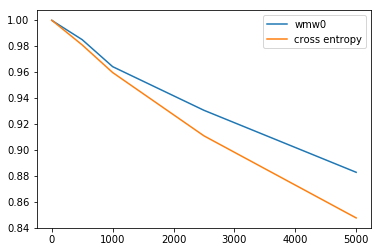

In [23]:
%matplotlib inline
wmwaucs_sig_np_bal = np.array([l[0] for l in wmwaucs_sig]).reshape((3,5,3,20,3)) #mu, p, count, iter, (testauc, accuracy, loss)
ceaucs_sig_np_bal = np.array([l[0] for l in ceaucs_sig]).reshape((3,5,3,20,3))
def plot(t,label=None):
    plt.plot(range(len(t)),t, label=label)
i=-1
plt.plot([1,500,1000,2500,5000],wmwaucs_sig_np_bal[2,:,:,i,0].mean(axis=1), label='wmw'+str(0))
plt.plot([1,500,1000,2500,5000],ceaucs_sig_np_bal[2,:,:,i,0].mean(axis=1), label='cross entropy')
plt.legend()

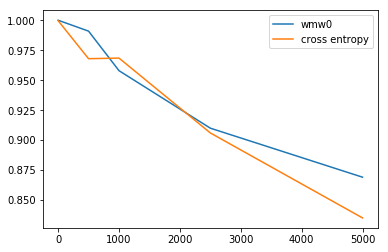

In [7]:
%matplotlib inline
def plot(t,label=None):
    plt.plot(range(len(t)),t, label=label)
i=-1
plt.plot([1,500,1000,2500,5000],wmwaucs_sig_np[2,:,:,i,0].mean(axis=1), label='wmw'+str(0))
plt.plot([1,500,1000,2500,5000],ceaucs_sig_np[2,:,:,i,0].mean(axis=1), label='cross entropy')
plt.legend()